## Evaluation of UTOPIA's performance in predicting MPs size dristributionsusing the monaco Monte Carlo framework 
#### (https://monaco.readthedocs.io/en/latest/)

With this script we preform an evaluation of UTOPIA's size distribution predictive capacity by comparing predicted size distributions in targeted compartmanes aginst observed MPs size distributions reported in the compilation of published datasets by Kooi et al.

### Import the necessary libraries

In [2]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_mc_analysis_paper, set_emission, sim_to_dataframe, reshape_mc_results
from utopia.monte_carlo.monte_carlo_helpers import *
from utopia.utopia import utopiaModel
import numpy as np
import scipy.stats as st
import pandas as pd

c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:18: UserWarning: Consider installing numba for better performance
  warn("Consider installing numba for better performance", UserWarning)


### Load the UTOPIA's default configuration parameters 

In [3]:
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")


### Define the parameter distributions for the Monte Carlo simulation.


Transform the discrete distributions to continuous distributions for compatibility with the current montecarlo function

In [4]:
import numpy as np
# To reproduce Rakesh results, use these following discrete values to then generate distributions (lognormal and uniform) from which to sample:

# Plastic density (mpdensity): [900, 1100, 1500] kg/m³ 
# Fragmentation style (FI): [0, 0.3, 0.5, 0.7, 1.0] - ranging from more erosive to more explosive fragmentation 
# Discorporation half time (thalf_deg): [316,1000,10000, 31600, 100000] days 
# Fragmentation timescale (thalf_frag): [10, 31.6, 100, 316] days
# your discrete support values

vals_density = np.array([900, 1100, 1500])
vals_FI = np.array([0, 0.3, 0.5, 0.7, 1.0])
vals_deg = np.array([316, 1000, 10000, 31600, 100000])
vals_frag = np.array([10, 31.6, 100, 316])

def lognorm_params_from_values(values, sigma):
    """
    Return (s, scale) for scipy.stats.lognorm given target values.
    sigma = shape parameter (spread in log space).
    We center the lognormal at the geometric mean of the values.
    """
    mu = np.mean(np.log(values))  # geometric mean in log-space
    scale = np.exp(mu - (sigma**2) / 2)
    return sigma, scale

# choose sigma to control spread (tune manually!)
s_deg, scale_deg = lognorm_params_from_values(vals_deg, sigma=0.5)
s_frag, scale_frag = lognorm_params_from_values(vals_frag, sigma=0.8)
s_density, scale_density = lognorm_params_from_values(vals_density, sigma=0.1)
s_FI, scale_FI = lognorm_params_from_values(vals_FI[vals_FI > 0], sigma=0.5)  # avoid zero for lognorm

param_distributions = {
    "MPdensity_kg_m3": ("lognorm", {"s": s_density, "scale": scale_density}),
    "FI": ("uniform", {"loc": 0.0, "scale": 1.0}),
    "t_half_deg_free": ("lognorm", {"s": s_deg, "scale": scale_deg}),
    "t_frag_gen_FreeSurfaceWater": ("lognorm", {"s": s_frag, "scale": scale_frag})
}



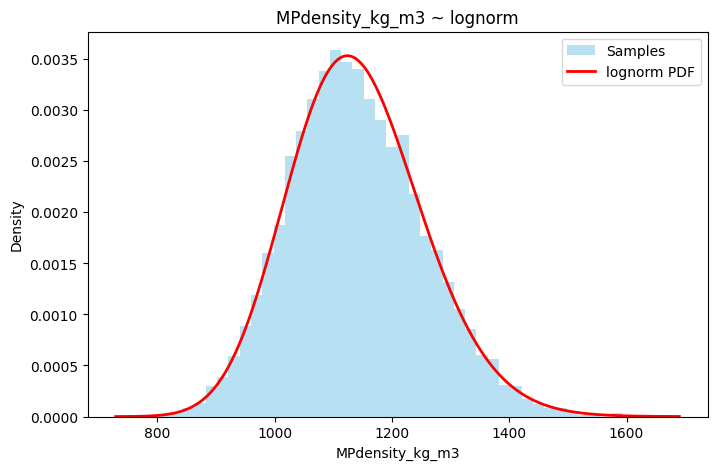

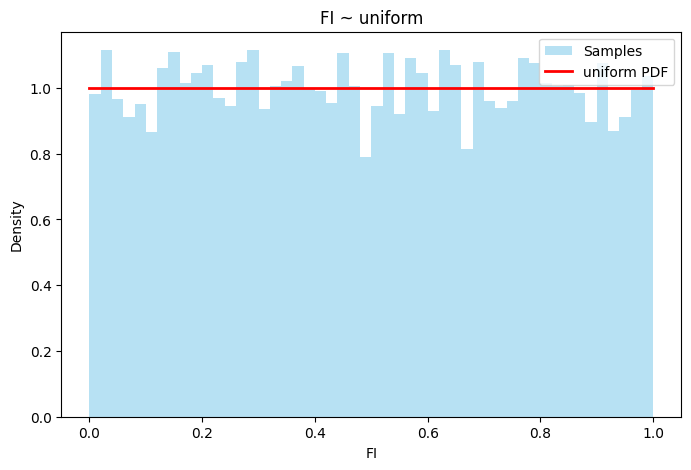

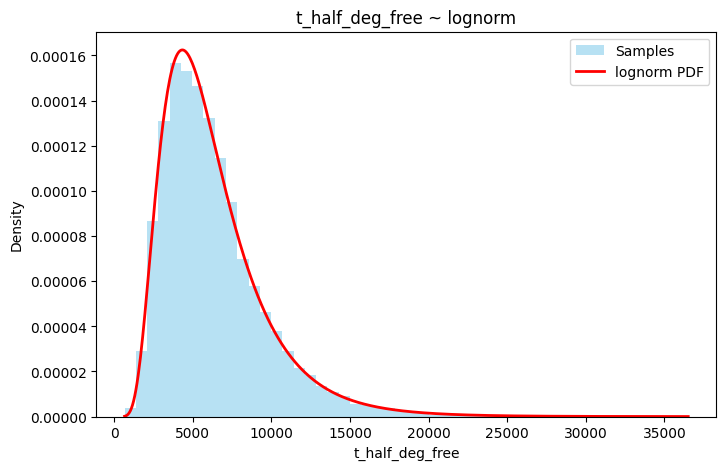

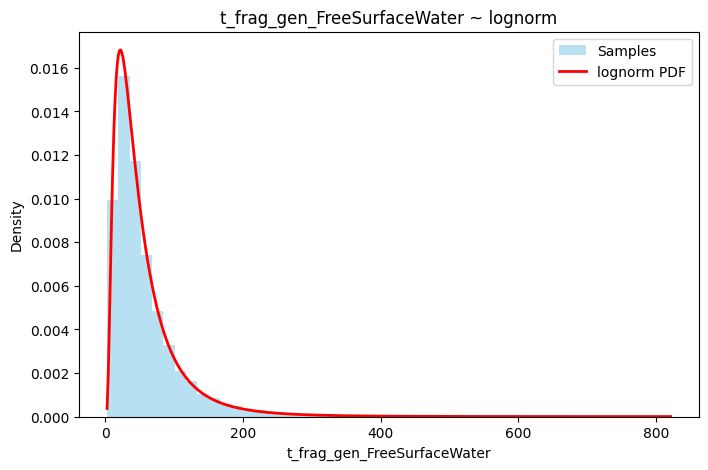

In [5]:
# Visualise the distributions by plotting

for psrsm in param_distributions:
    plot_distribution_from_dict(psrsm, param_distributions)

In [6]:

# Recent studies have challenged the density of biofilm used here (1388 kg m-3) as being too high. see e.g. # https://doi.org/10.1186/s43591-024-00098-2 
# Consider testing chnages in biofouling density

In [6]:
# Set emission scenarios to run that are compatible for comparison with observations data from Kooi et al.

##############################################
# DEFINE ARTICLE -> EMISSION SCENARIOS
##############################################

overlay_emission_scenarios = {
    "Sea Sediment | Bergmann":["Ocean_Surface_Water","Coast_Surface_Water","Coast_Column_Water"],
    "Sea Surface all | Cai":["Surface_Freshwater","Coast_Surface_Water","Impacted_Soil_Surface"],
    "Sea Surface Fragments | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Sea Surface Fibers | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Fragments in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fragments in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Erni-Cassola":["Coast_Surface_Water","Impacted_Soil_Surface"],
    "Fresh water sediments | Imhof":["Surface_Freshwater","Impacted_Soil_Surface"],
    "Sea Surface all | Isobe L1":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L2":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L3":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L4":["Surface_Freshwater","Coast_Surface_Water"],
    "FP all | Scheurer":["Impacted_Soil_Surface"],
    "Sea Surface Fragments | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface Fibers | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Zhang":["Coast_Surface_Water","Surface_Freshwater"]}
    
    
    
    
# DEFINE ARTICLE->COMPARTMENTS MAPPING
#############################################
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Sediment_Freshwater"],
    "Fibers in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe L1": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L2": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer": ["Impacted_Soil_Surface", "Sediment_Freshwater"], 
    "Sea Surface Fragments | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

# NOTE!I have ch anged the mapping for the FP all | Scheurer study compared to the original data from Rakesh. Samples were collected in floodplain soils, so the impacted_soil_surface compartment and freshwater sediment compartment have been included in the compartment mapping.might be more appropriate. Since the model does not simulate floodplain soils as a separate compartment.?

# NOTE 2! Changed entry in overlay compatrments mapping for the "Fragments in sediment | Eo" and "Fibers in sediment | Eo" studies to exclude the beaches compartments. 

In [11]:
# Set emission scenarios according to the mapping defined above to the run the model for each parameter combination using the Monte Carlo framework and perform the comparison with the observed data according to mapping.

Test difference in results if run with distributions or single values for the parameters for one article

Running Monte Carlo analysis for article: Sea Sediment | Bergmann
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:14<00:34,  2.48s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:21<00:25,  2.36s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5997.86 cases/s]

Simulation complete! Runtime: 0:00:45.844982
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:32,  2.29s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:26,  2.37s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 30470.79 cases/s]

Simulation complete! Runtime: 0:00:45.169583
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:12<00:30,  2.17s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:23,  2.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:45.858922
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:30,  2.21s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:23,  2.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:43.172311
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:12<00:28,  2.06s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:18<00:22,  2.06s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7577.10 cases/s]

Simulation complete! Runtime: 0:00:40.316425
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:12<00:28,  2.04s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:18<00:21,  1.97s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5866.98 cases/s] 

Simulation complete! Runtime: 0:00:39.911975


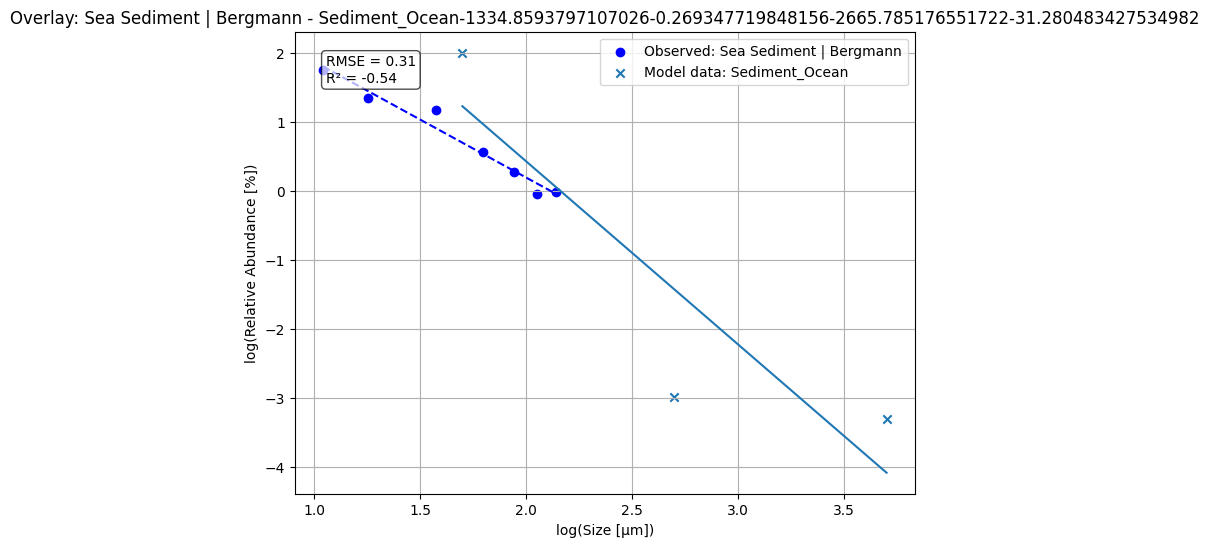

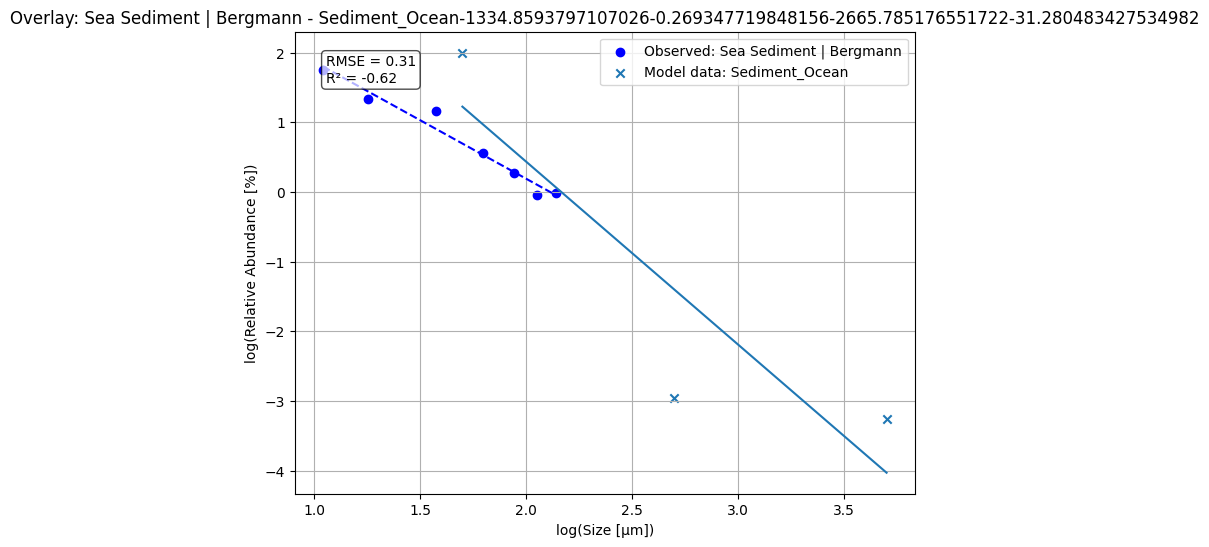

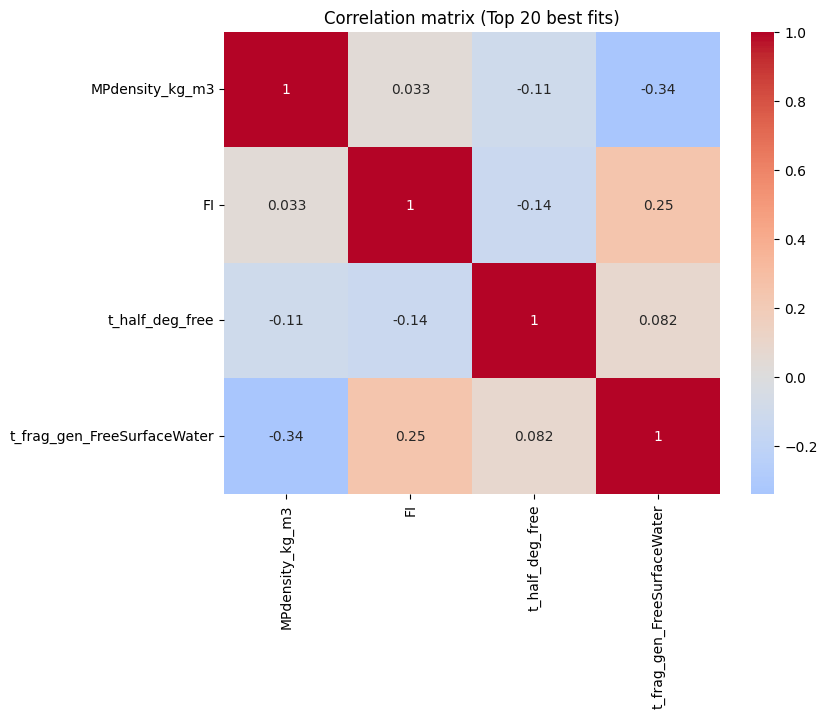

Running Monte Carlo analysis for article: Sea Surface all | Cai
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 10001.92 cases/s]

Simulation complete! Runtime: 0:00:46.848204
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9986.44 cases/s]

Simulation complete! Runtime: 0:00:47.376523
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4584.44 cases/s]

Simulation complete! Runtime: 0:00:44.439927
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:43.766181
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4951.37 cases/s]

Simulation complete! Runtime: 0:00:41.710406
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4453.26 cases/s] 

Simulation complete! Runtime: 0:00:41.845000


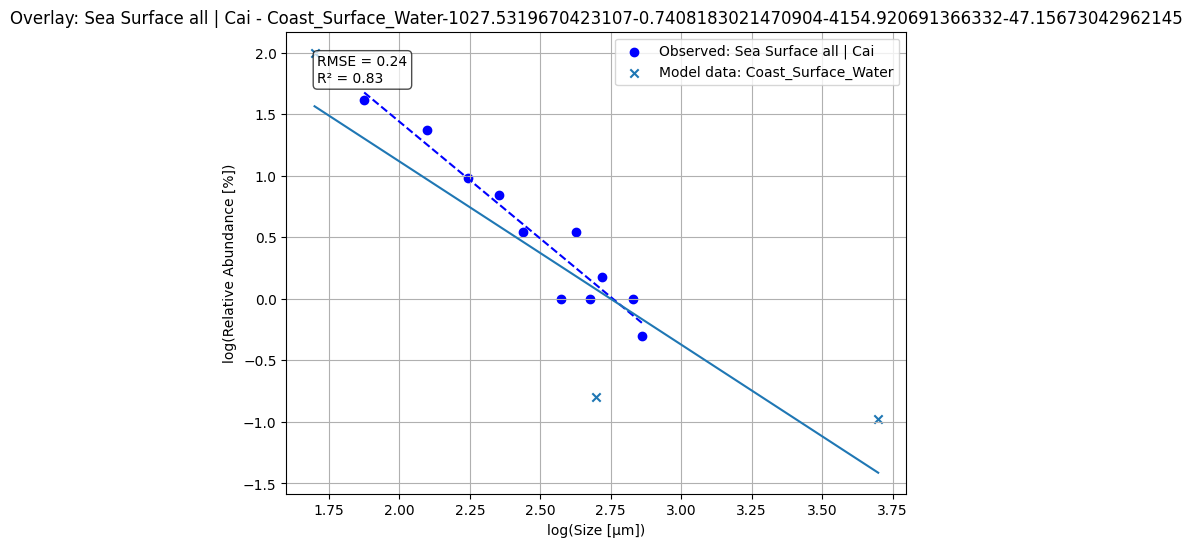

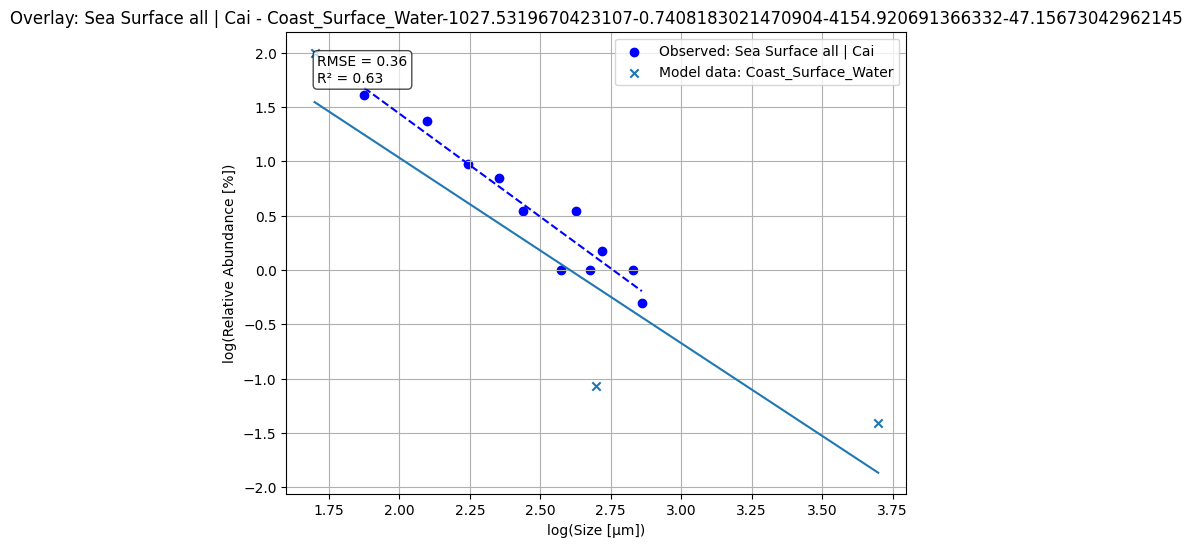

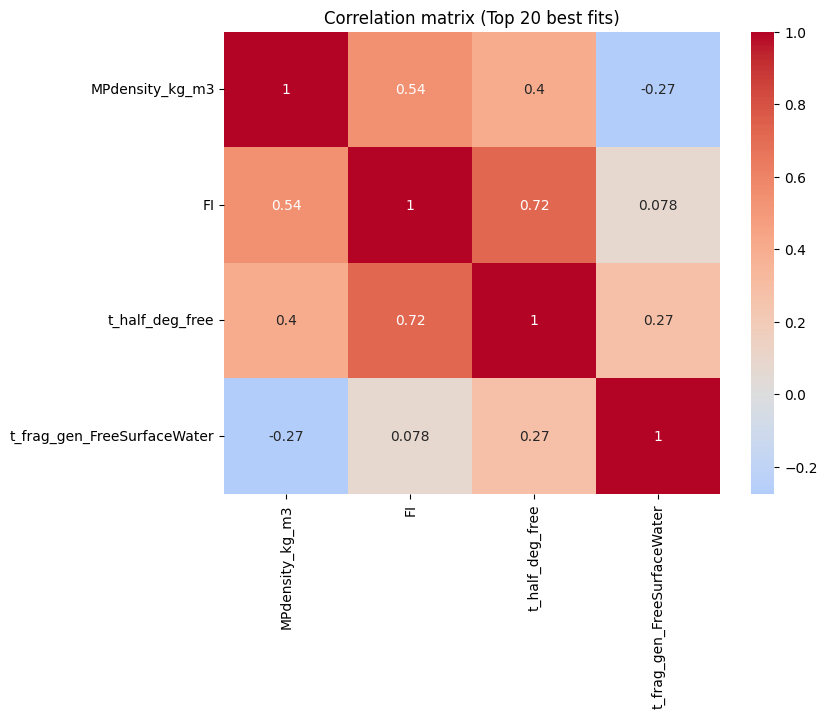

Running Monte Carlo analysis for article: Sea Surface Fragments | Enders
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7738.57 cases/s]

Simulation complete! Runtime: 0:00:43.992502
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4688.73 cases/s]

Simulation complete! Runtime: 0:00:53.302327
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.482305
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2286.60 cases/s]

Simulation complete! Runtime: 0:00:41.710774


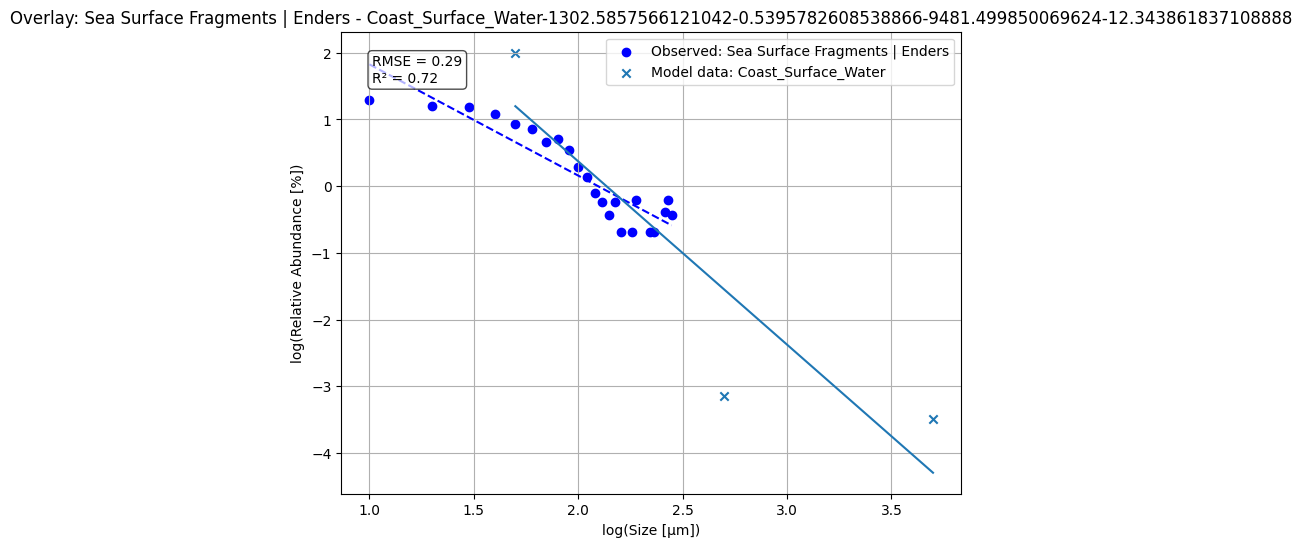

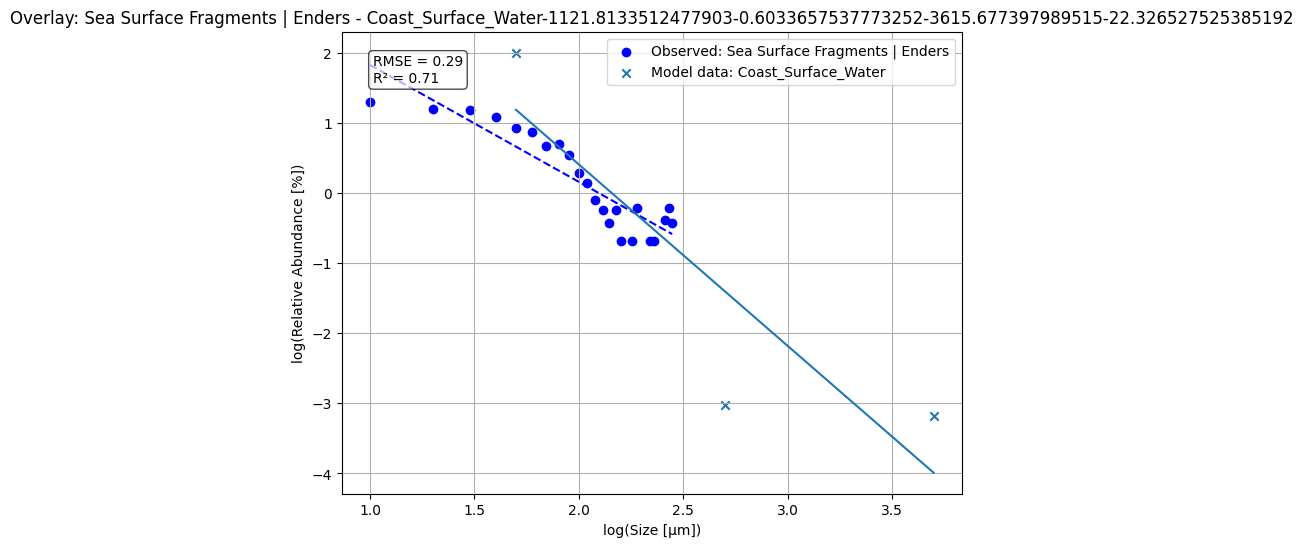

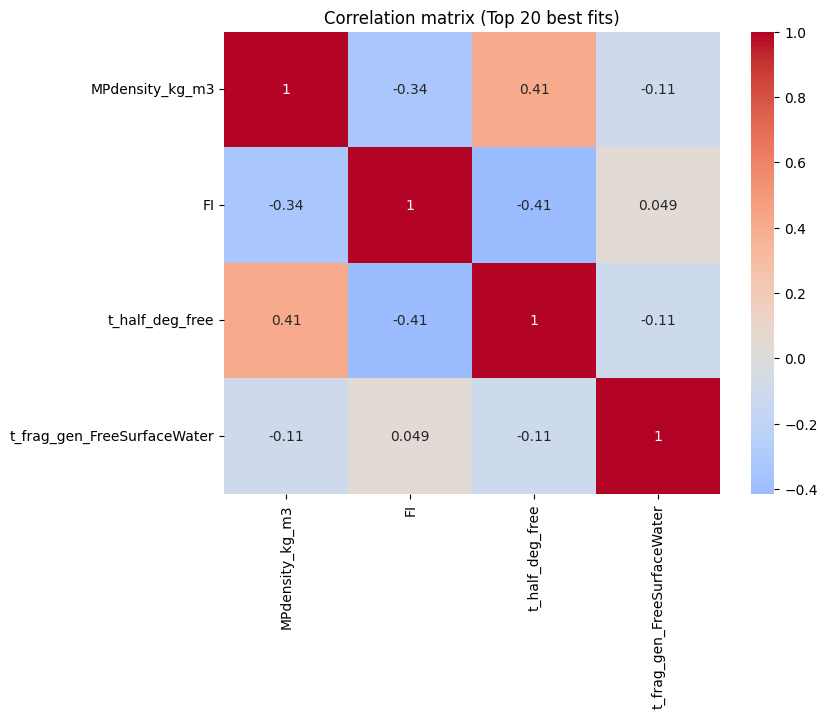

Running Monte Carlo analysis for article: Sea Surface Fibers | Enders
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1855.31 cases/s]

Simulation complete! Runtime: 0:00:52.536643
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6639.18 cases/s]

Simulation complete! Runtime: 0:00:56.359340
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5690.66 cases/s]

Simulation complete! Runtime: 0:00:54.034651
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7932.49 cases/s]

Simulation complete! Runtime: 0:01:02.951710


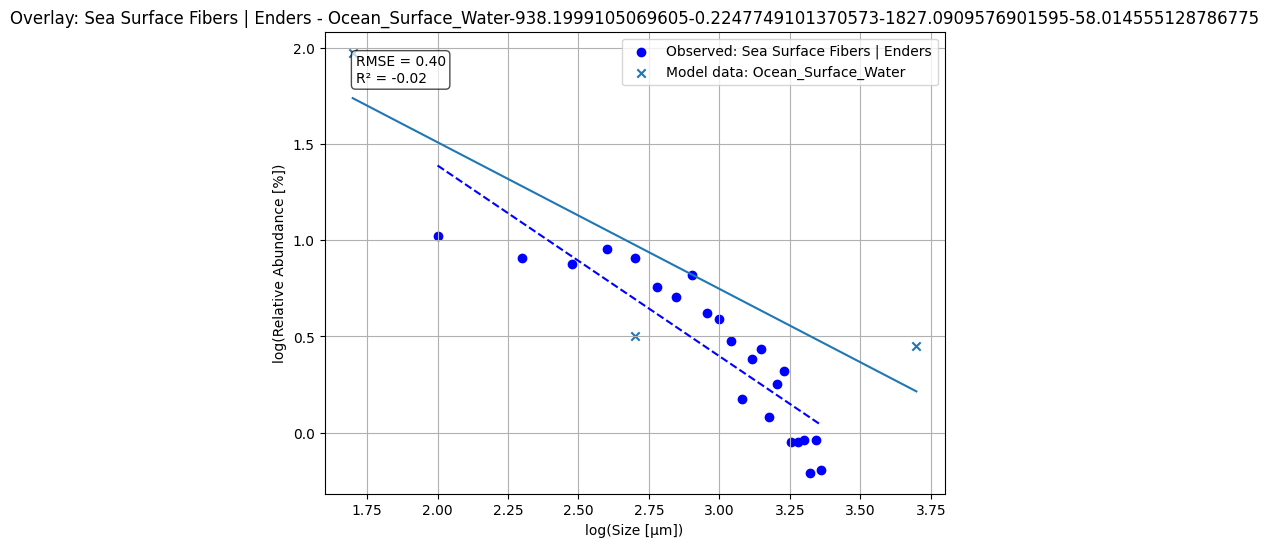

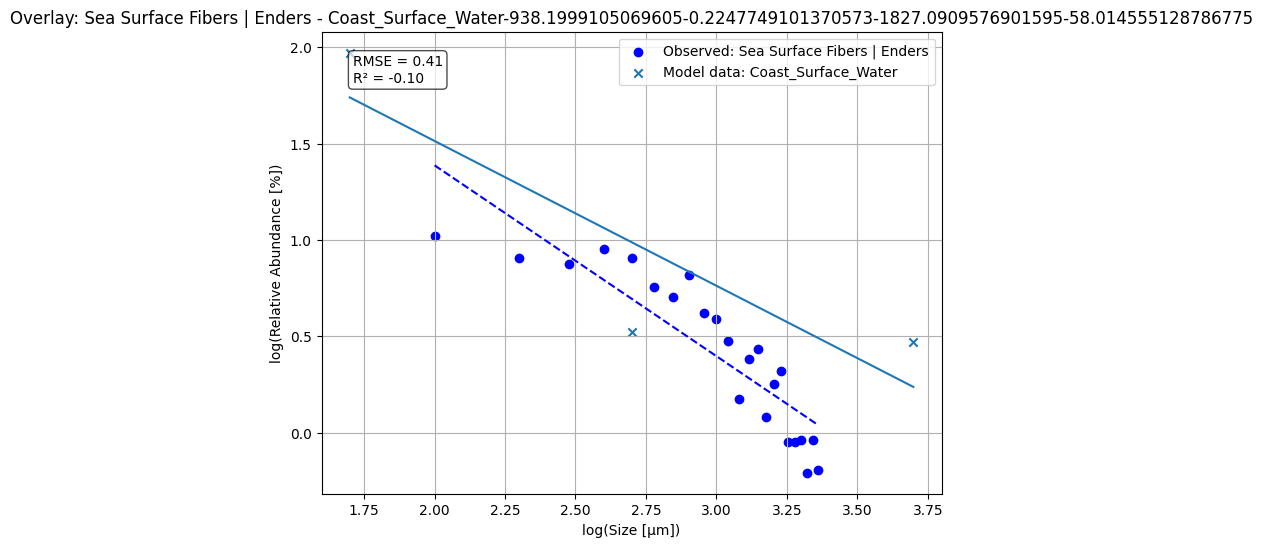

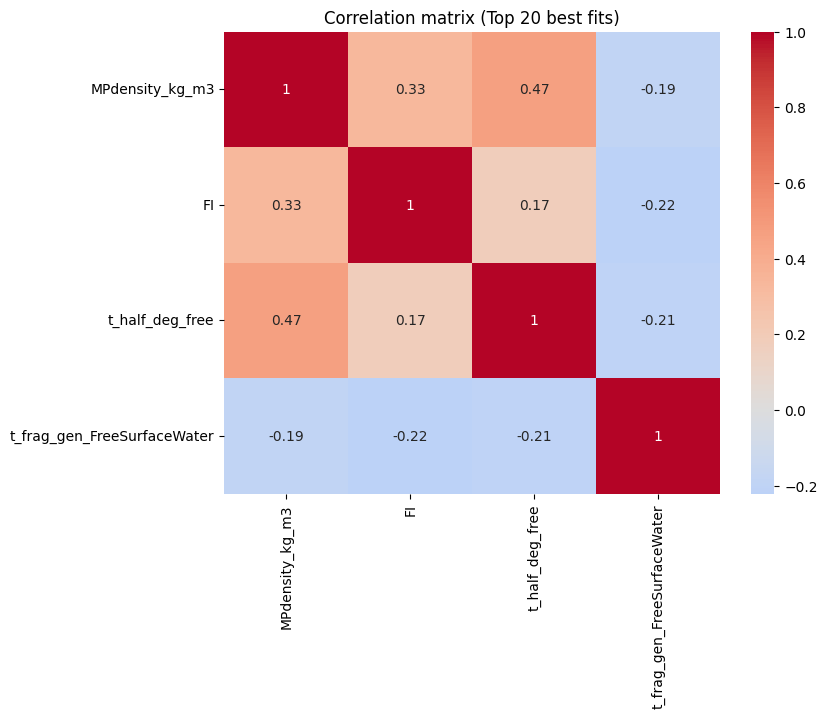

Running Monte Carlo analysis for article: Fragments in water | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5979.90 cases/s]

Simulation complete! Runtime: 0:00:58.355775
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9999.53 cases/s] 

Simulation complete! Runtime: 0:00:59.462024
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6157.23 cases/s]

Simulation complete! Runtime: 0:00:56.327789
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5242.22 cases/s]

Simulation complete! Runtime: 0:00:57.831758


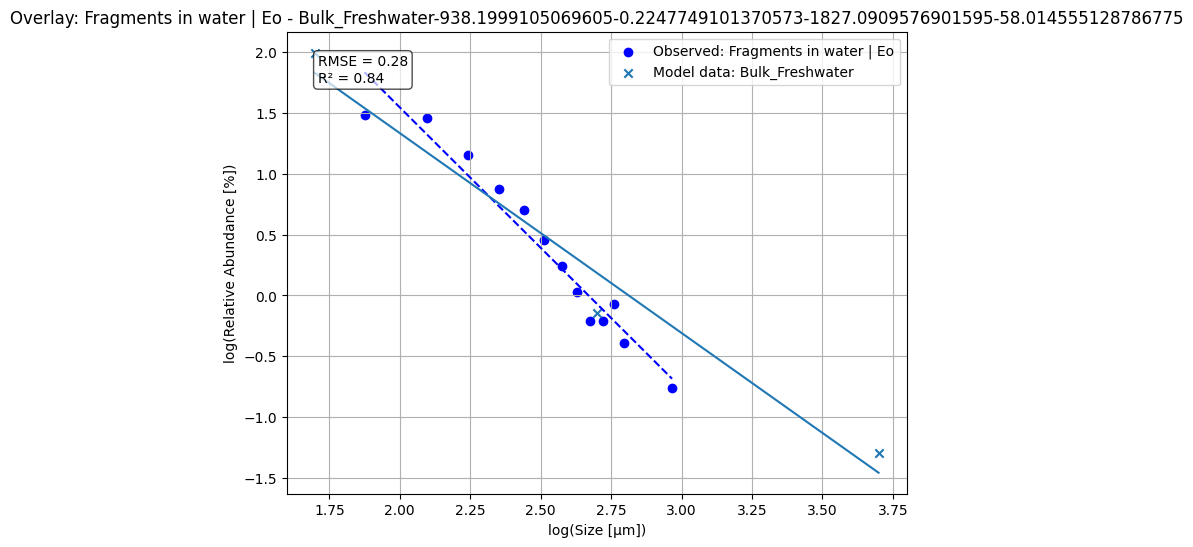

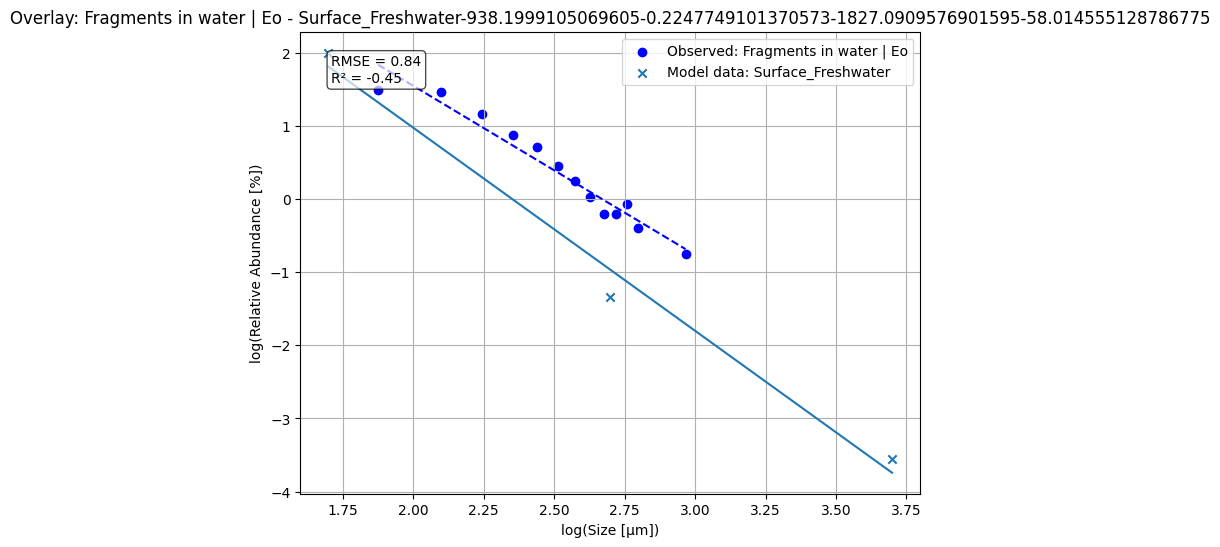

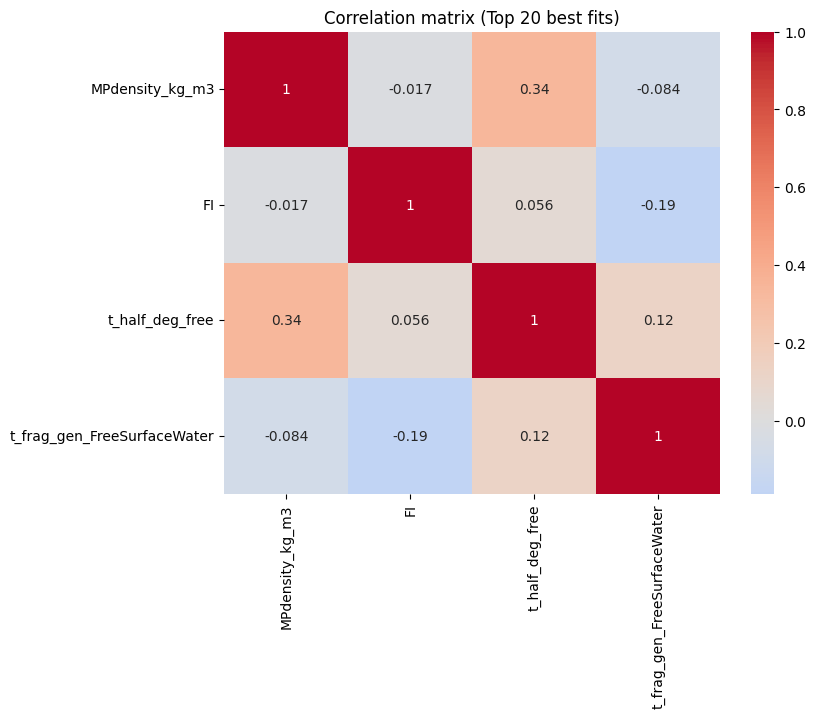

Running Monte Carlo analysis for article: Fibers in water | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1716.97 cases/s]

Simulation complete! Runtime: 0:00:56.934235
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 19854.69 cases/s]

Simulation complete! Runtime: 0:00:53.153028
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6191.77 cases/s]

Simulation complete! Runtime: 0:00:52.885237
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6659.74 cases/s]

Simulation complete! Runtime: 0:00:52.989302


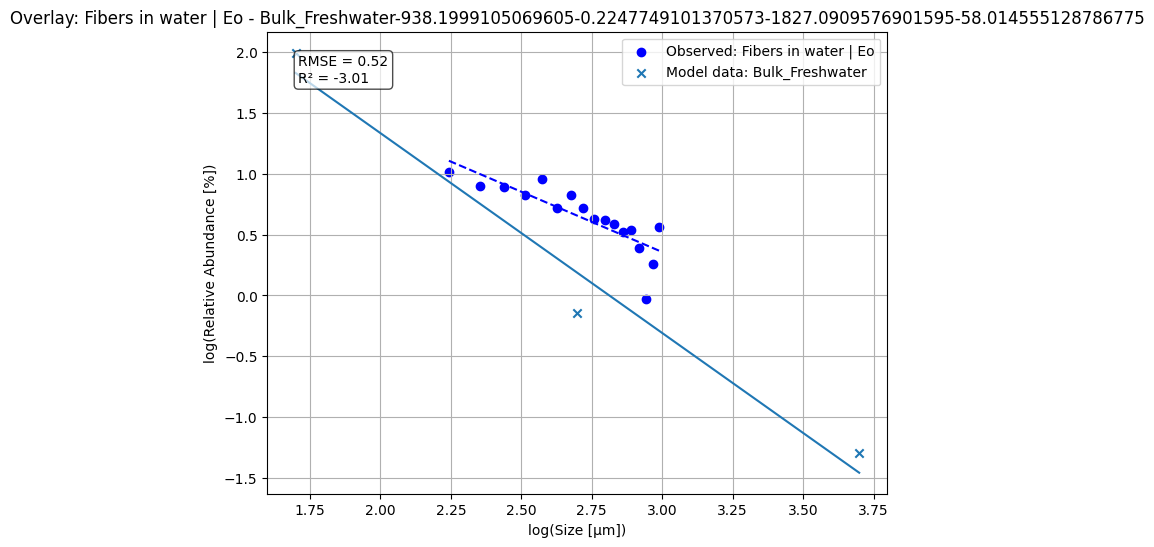

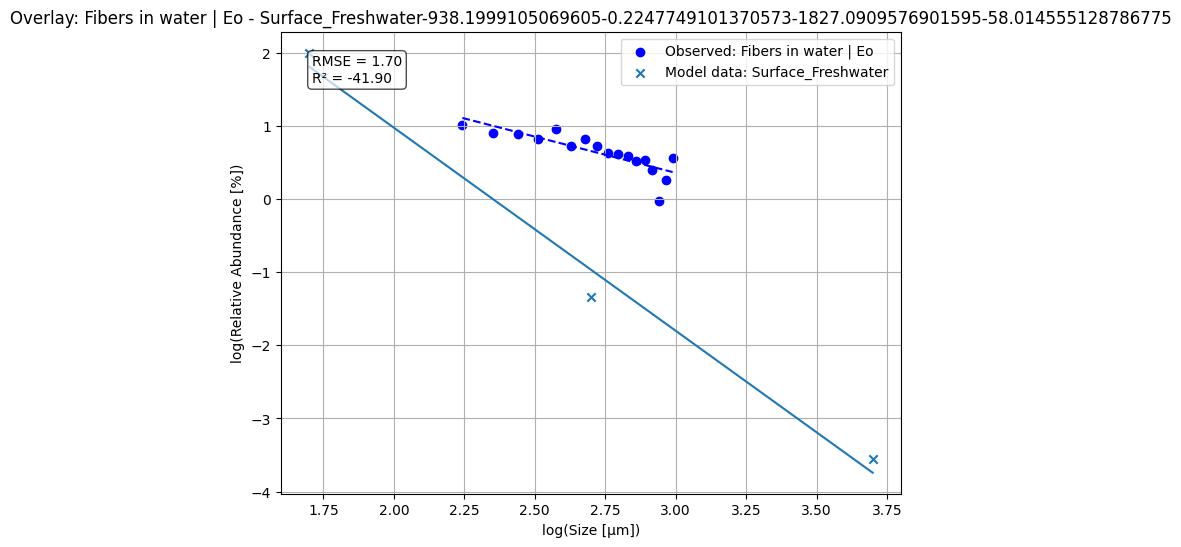

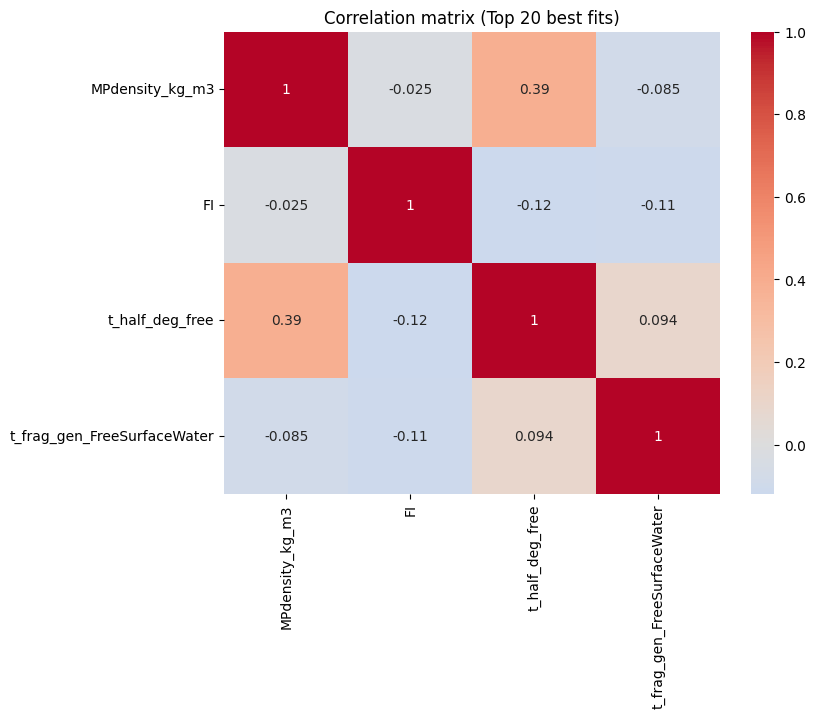

Running Monte Carlo analysis for article: Fragments in sediment | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:15<00:37,  2.69s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:23<00:29,  2.65s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4455.63 cases/s]

Simulation complete! Runtime: 0:00:52.630852
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:16<00:39,  2.85s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:25<00:33,  3.00s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5000.96 cases/s]

Simulation complete! Runtime: 0:01:03.370459
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:44,  3.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6641.81 cases/s] 

Simulation complete! Runtime: 0:01:02.746842
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:43,  3.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:28<00:34,  3.13s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4649.23 cases/s]

Simulation complete! Runtime: 0:01:02.674916
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:19<00:45,  3.22s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:29<00:35,  3.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5687.58 cases/s]

Simulation complete! Runtime: 0:01:03.990834
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:43,  3.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4751.14 cases/s]

Simulation complete! Runtime: 0:01:05.921732


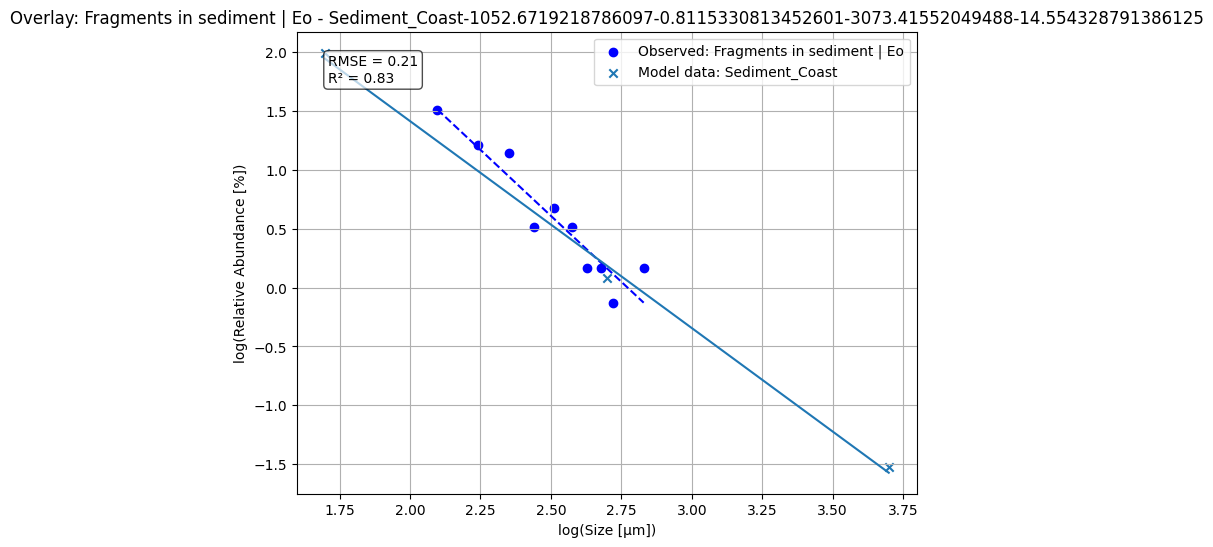

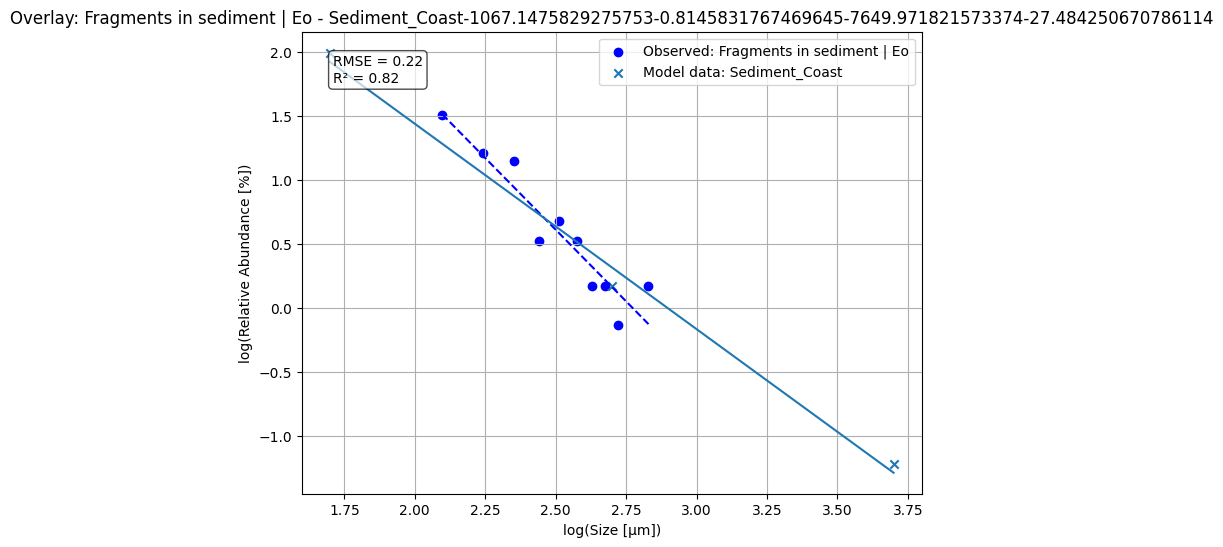

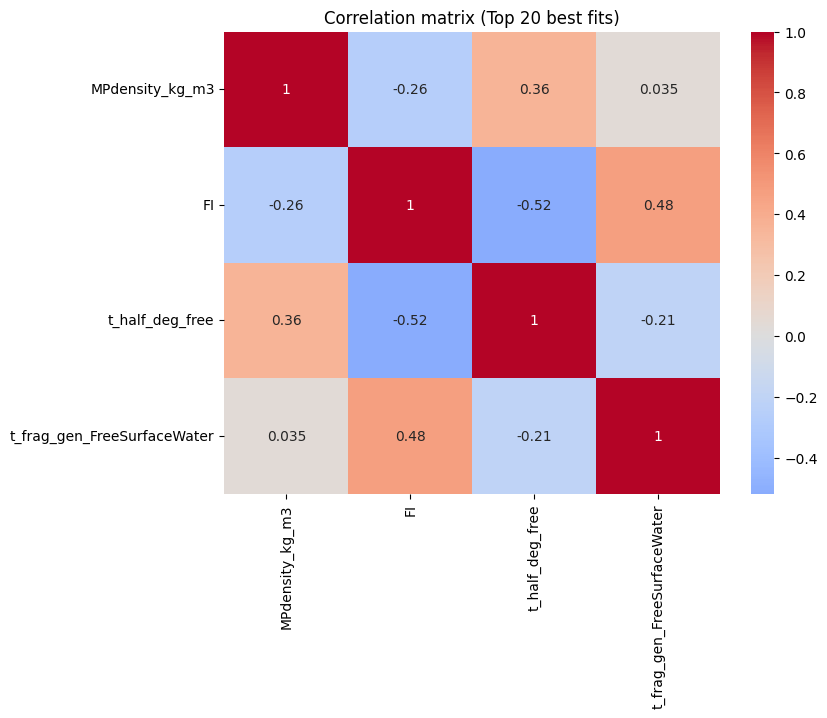

Running Monte Carlo analysis for article: Fibers in sediment | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:23<00:55,  3.94s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:33<00:37,  3.45s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3612.51 cases/s]

Simulation complete! Runtime: 0:01:08.086630
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:44,  3.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:28<00:35,  3.21s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5173.36 cases/s] 

Simulation complete! Runtime: 0:01:03.757171
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:19<00:44,  3.17s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5681.03 cases/s]

Simulation complete! Runtime: 0:01:03.830703
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:43,  3.13s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:28<00:34,  3.11s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2900.32 cases/s]

Simulation complete! Runtime: 0:01:02.363108
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:44,  3.14s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:29<00:38,  3.51s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5005.14 cases/s]

Simulation complete! Runtime: 0:01:12.173422
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:18<00:43,  3.10s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6665.03 cases/s] 

Simulation complete! Runtime: 0:01:03.211953


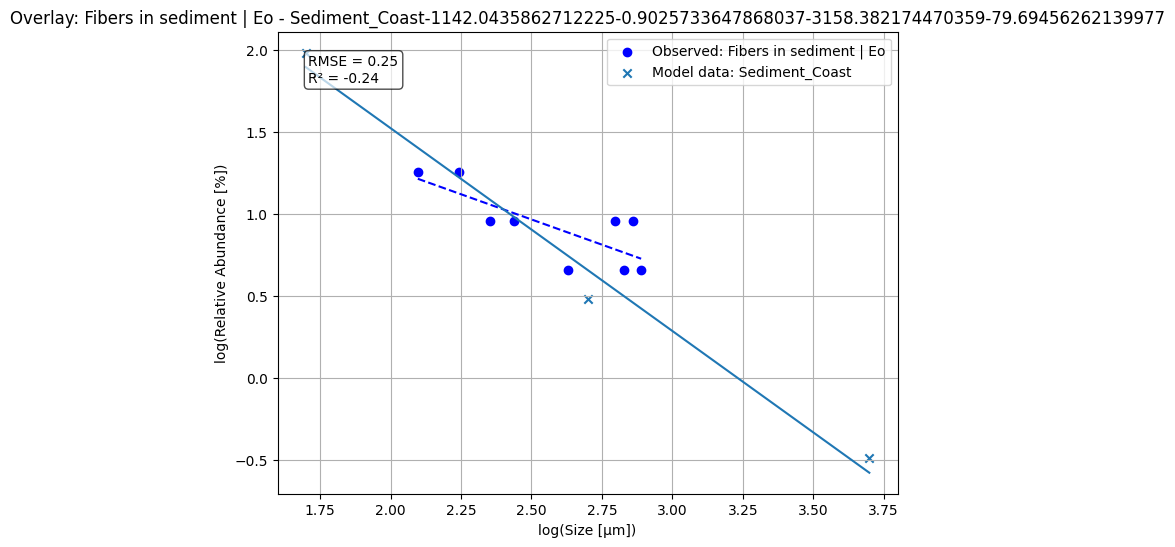

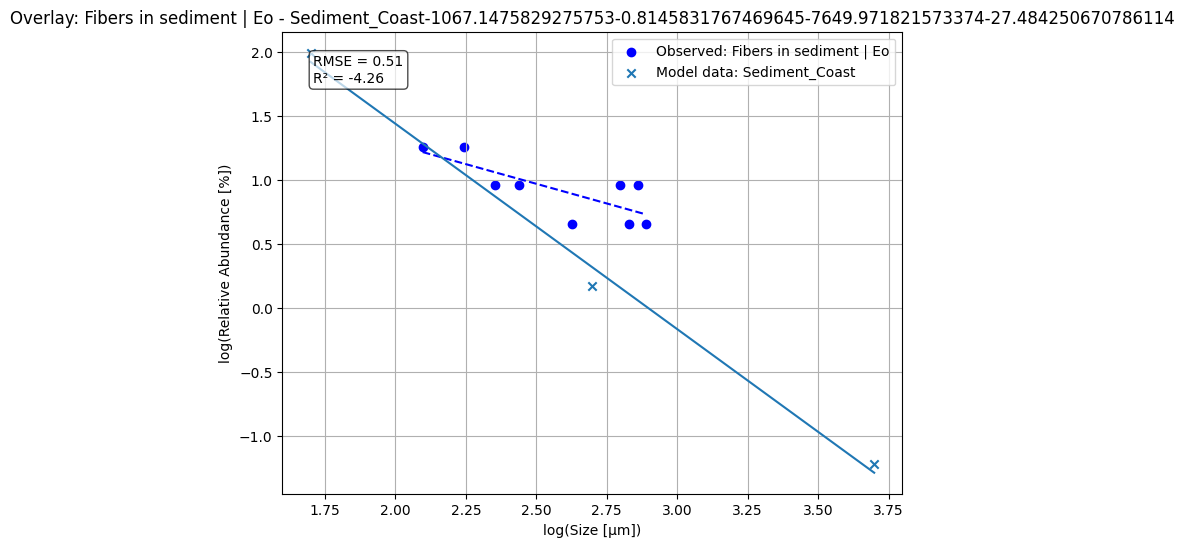

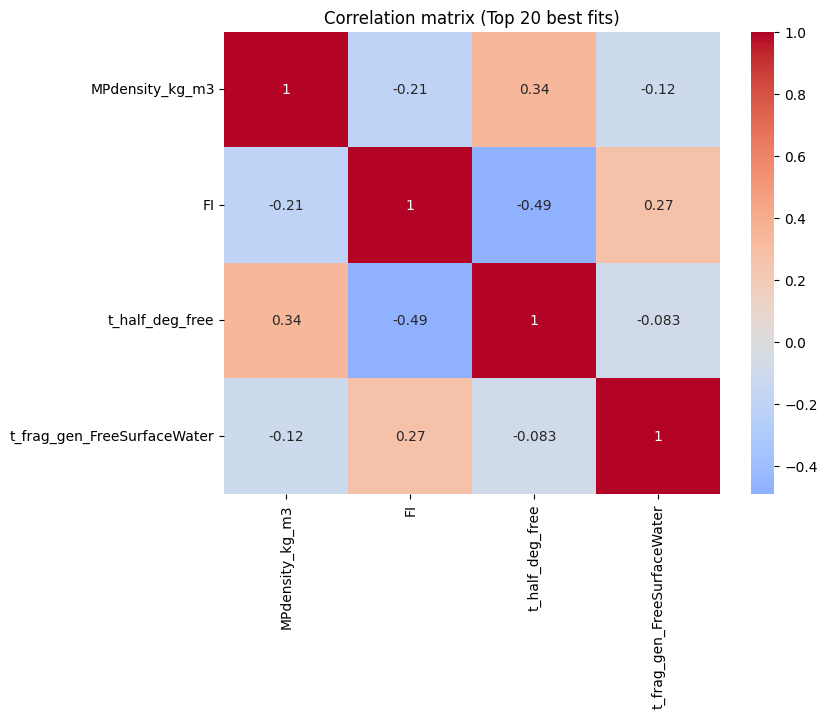

Running Monte Carlo analysis for article: Sea Surface all | Erni-Cassola
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5681.03 cases/s]

Simulation complete! Runtime: 0:01:04.222335
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4953.12 cases/s]

Simulation complete! Runtime: 0:01:03.481616
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7985.35 cases/s] 

Simulation complete! Runtime: 0:00:58.731313
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6365.62 cases/s]

Simulation complete! Runtime: 0:01:01.083154


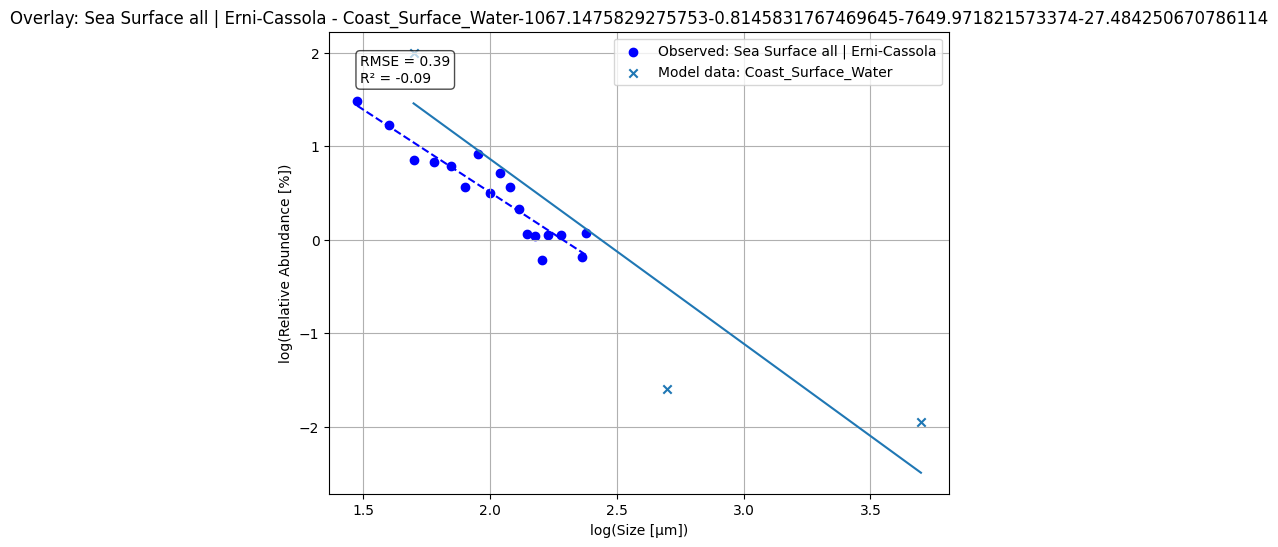

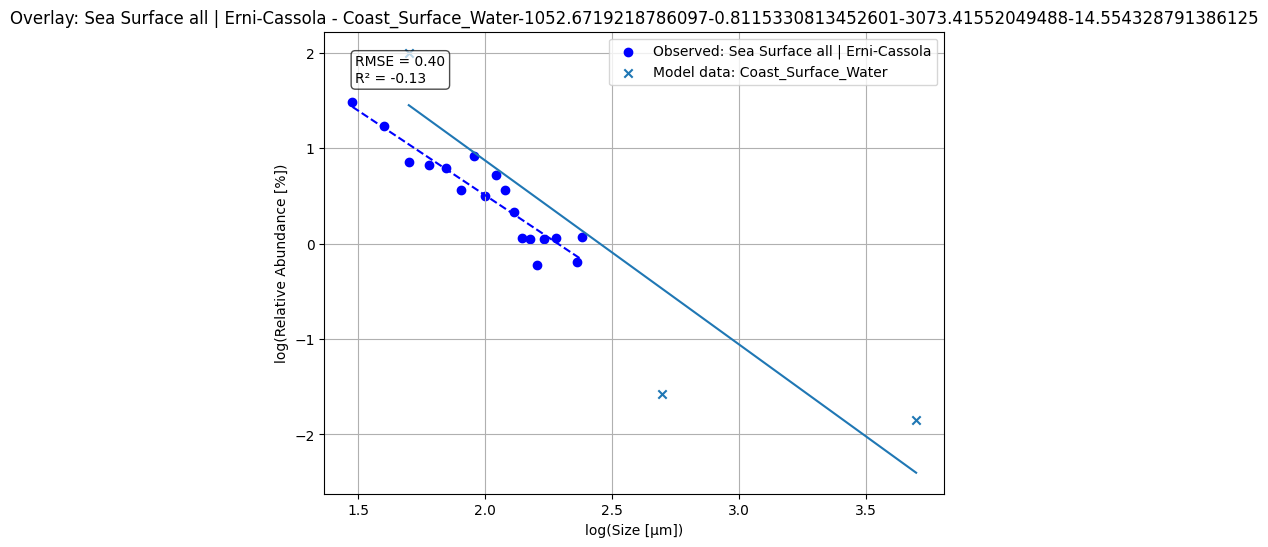

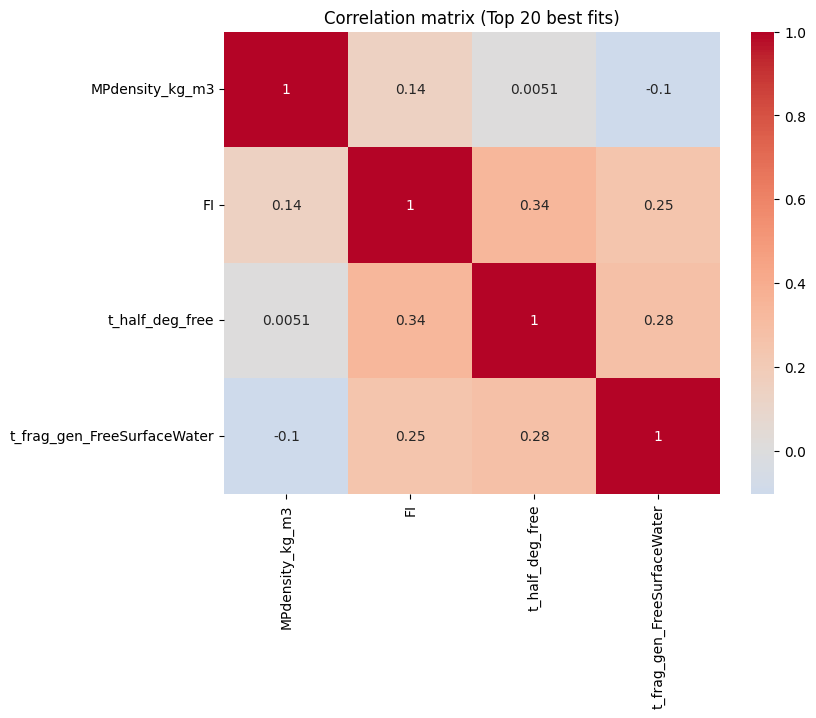

Running Monte Carlo analysis for article: Fresh water sediments | Imhof
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5056.73 cases/s] 

Simulation complete! Runtime: 0:00:54.128064
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5664.15 cases/s]

Simulation complete! Runtime: 0:00:54.024356
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4997.98 cases/s]

Simulation complete! Runtime: 0:00:57.298399
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3892.08 cases/s]

Simulation complete! Runtime: 0:01:05.362124


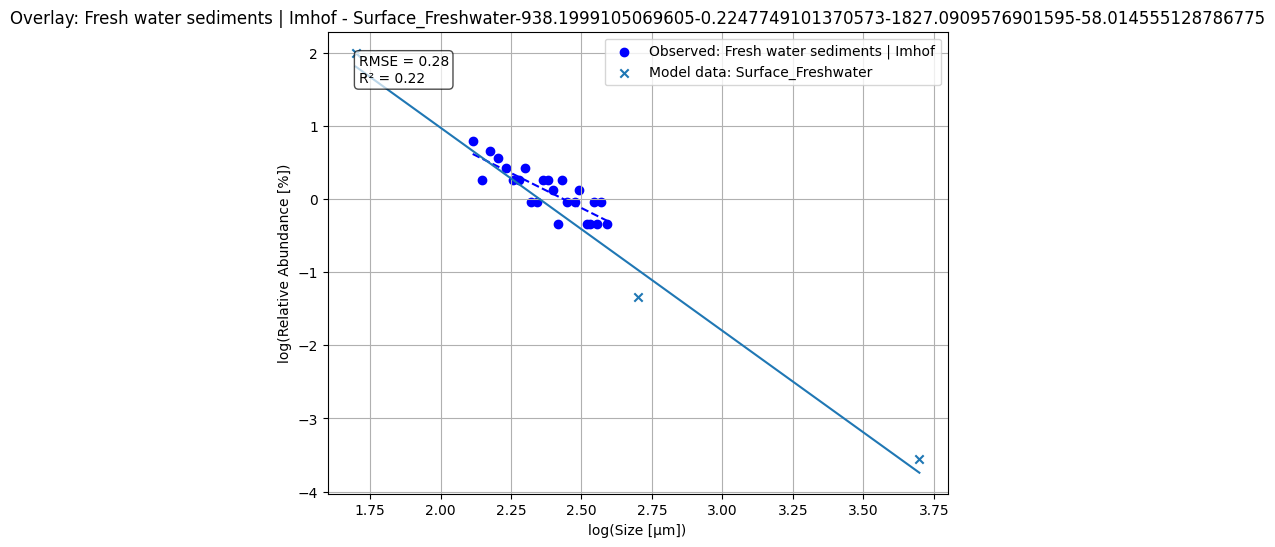

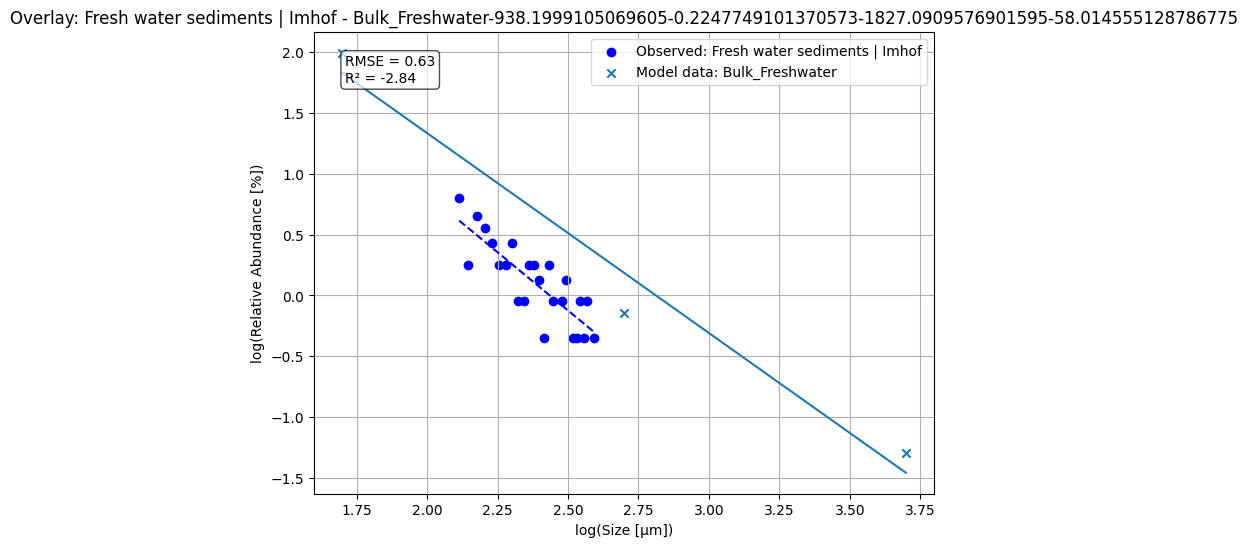

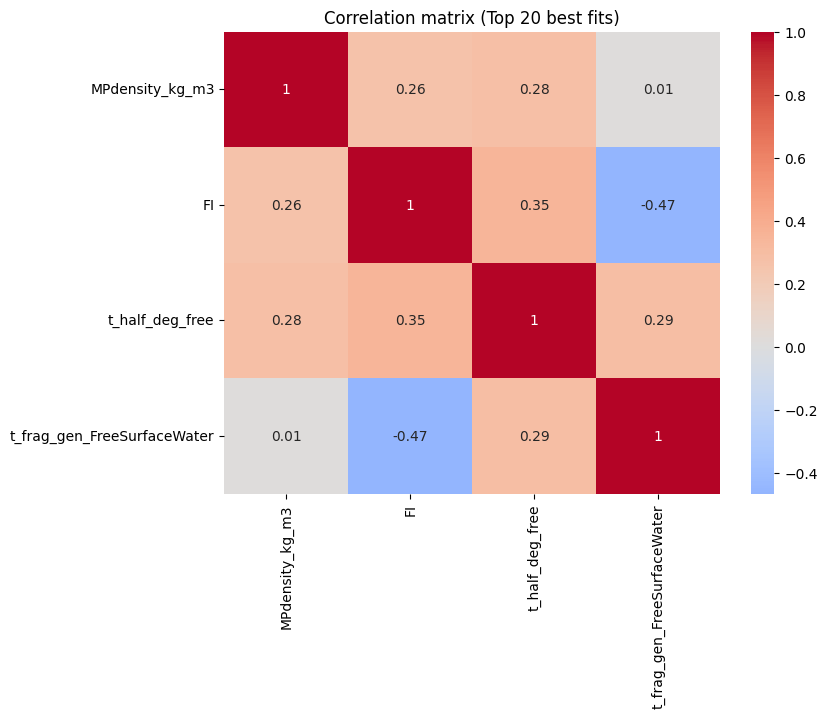

Running Monte Carlo analysis for article: Sea Surface all | Isobe L1
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5598.75 cases/s]

Simulation complete! Runtime: 0:01:10.617718
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4080.86 cases/s] 

Simulation complete! Runtime: 0:01:02.640038
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4002.20 cases/s]

Simulation complete! Runtime: 0:01:02.079165
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4948.74 cases/s]

Simulation complete! Runtime: 0:01:03.855236


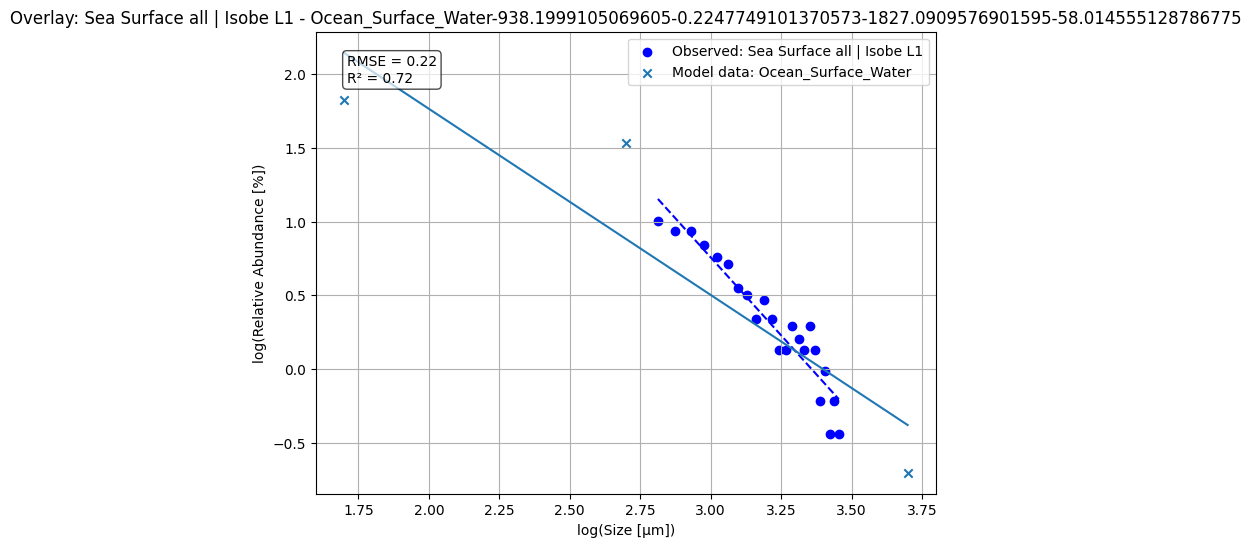

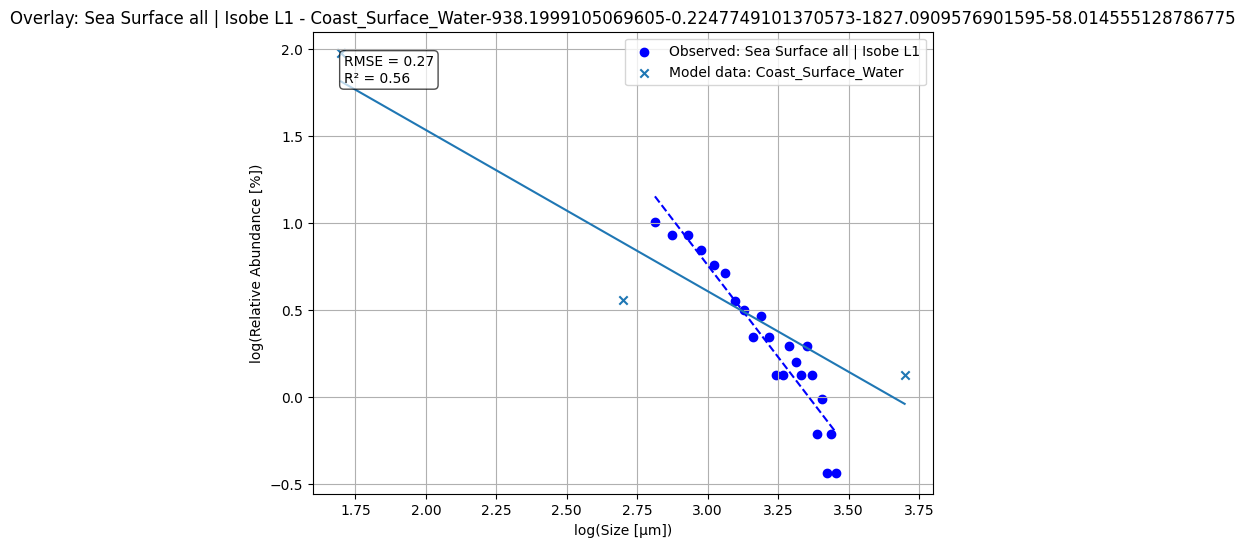

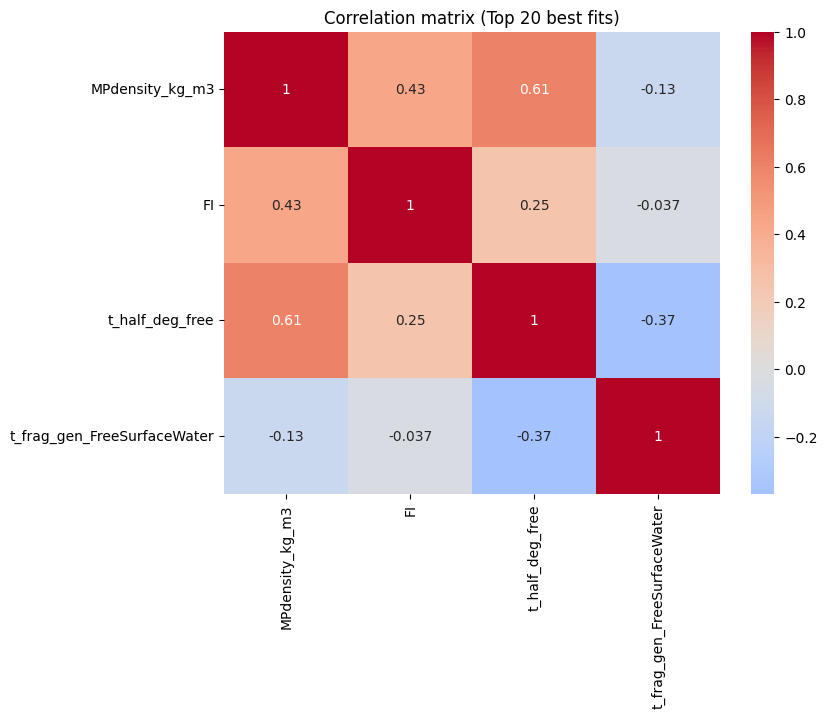

Running Monte Carlo analysis for article: Sea Surface all | Isobe L2
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4362.02 cases/s]

Simulation complete! Runtime: 0:01:10.220427
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6671.92 cases/s]

Simulation complete! Runtime: 0:00:53.929780
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6656.57 cases/s]

Simulation complete! Runtime: 0:00:54.140145
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6625.03 cases/s] 

Simulation complete! Runtime: 0:00:54.371634


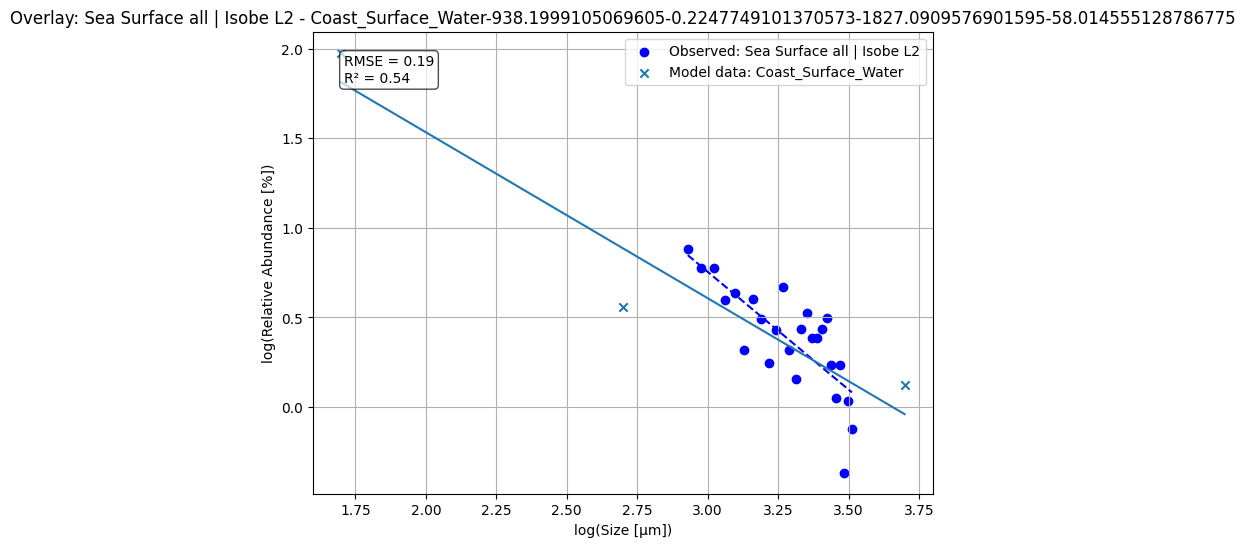

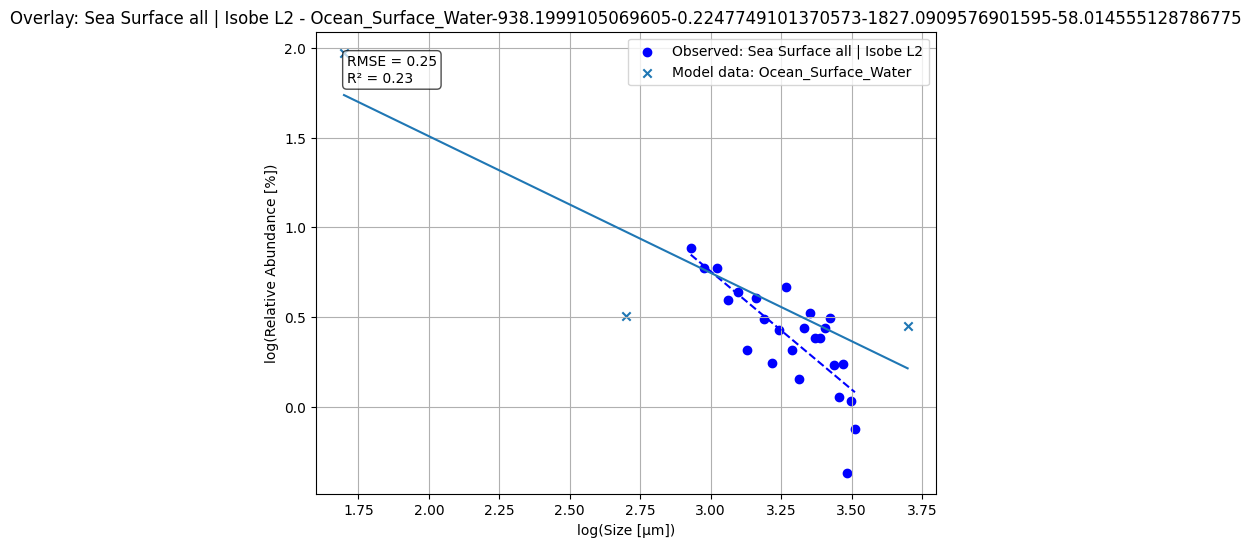

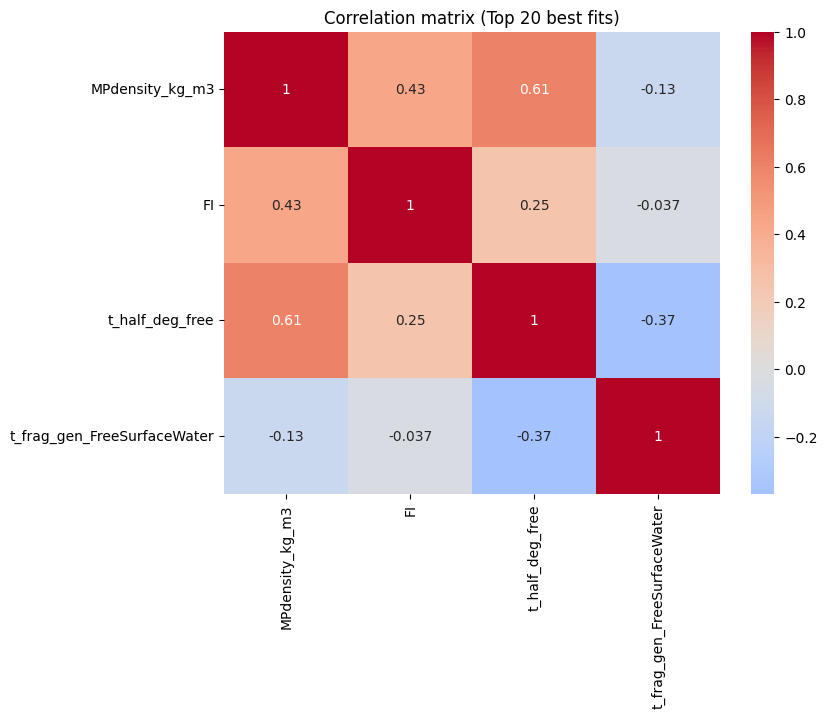

Running Monte Carlo analysis for article: Sea Surface all | Isobe L3
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4914.82 cases/s]

Simulation complete! Runtime: 0:00:54.342452
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4991.14 cases/s]

Simulation complete! Runtime: 0:00:58.049601
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5002.45 cases/s]

Simulation complete! Runtime: 0:00:57.452560
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5356.37 cases/s] 

Simulation complete! Runtime: 0:00:54.453260


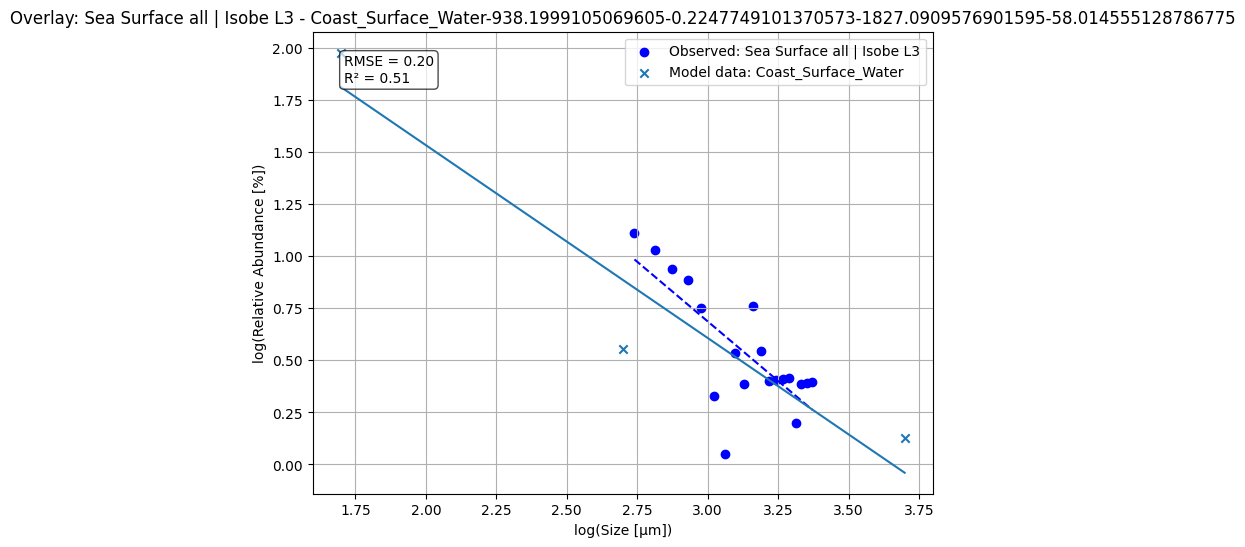

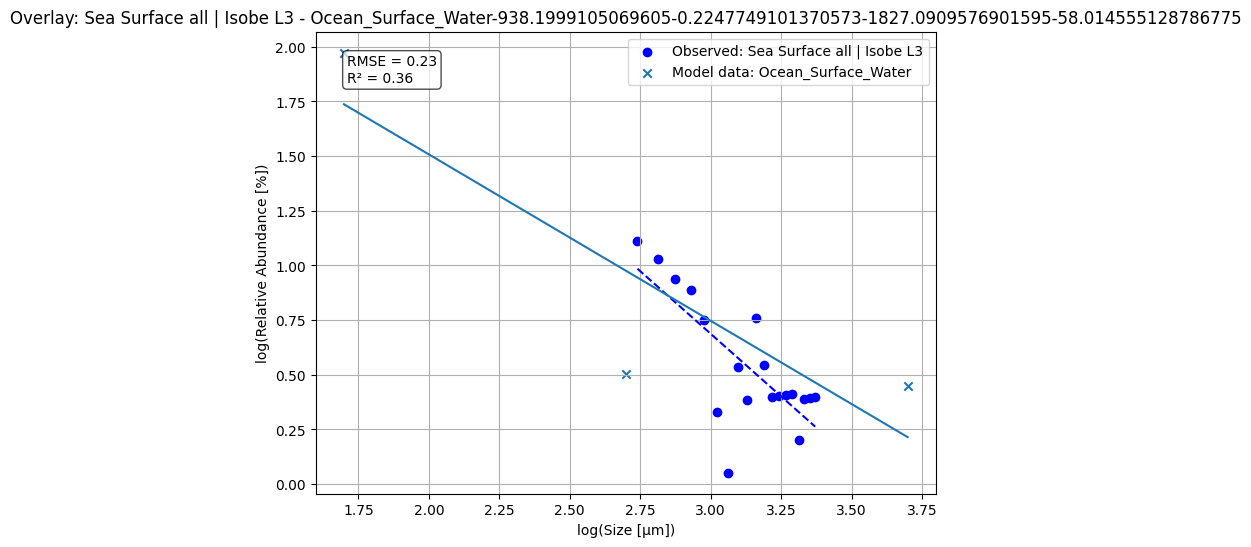

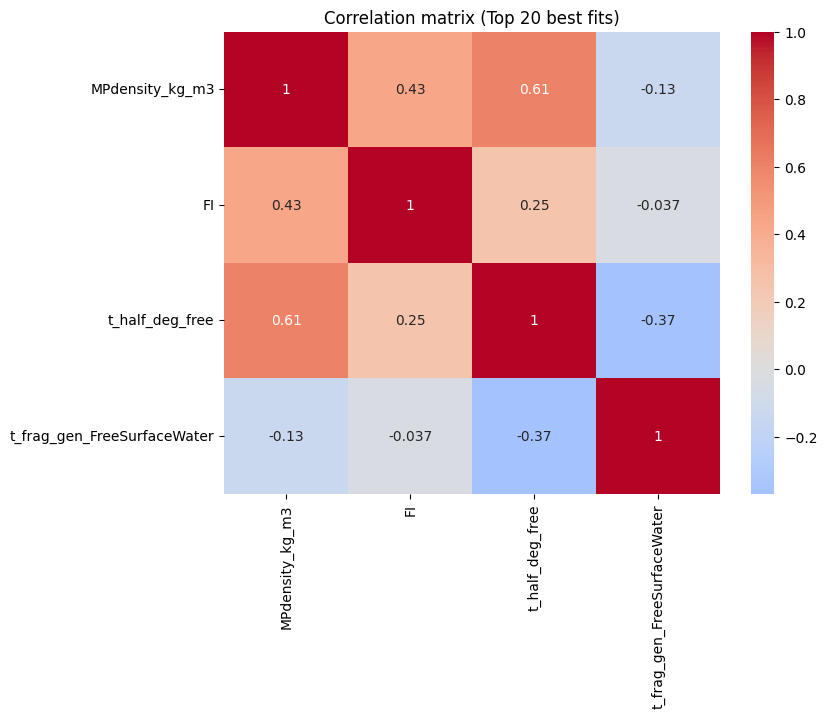

Running Monte Carlo analysis for article: Sea Surface all | Isobe L4
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4660.60 cases/s]

Simulation complete! Runtime: 0:00:53.902362
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5696.07 cases/s]

Simulation complete! Runtime: 0:00:54.058771
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5681.41 cases/s]

Simulation complete! Runtime: 0:00:56.054505
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3978.09 cases/s]

Simulation complete! Runtime: 0:01:09.283120


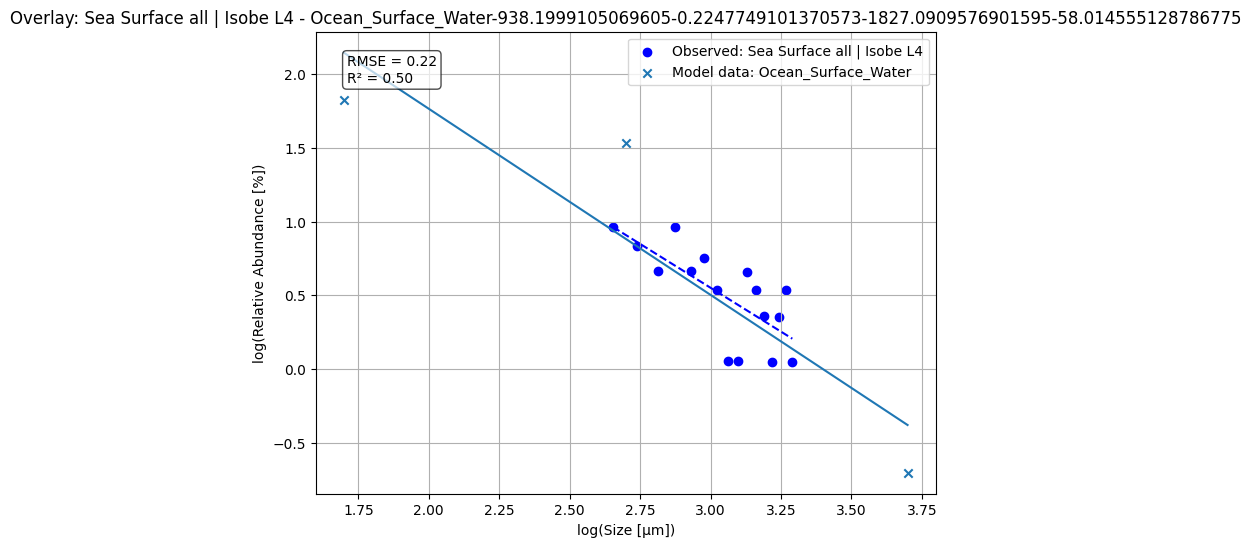

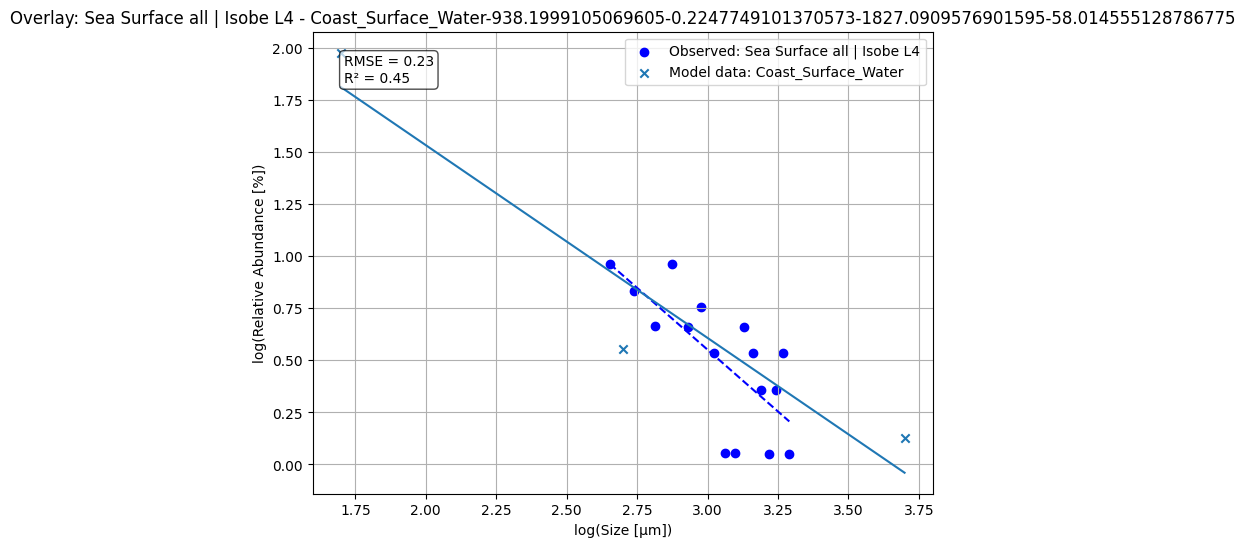

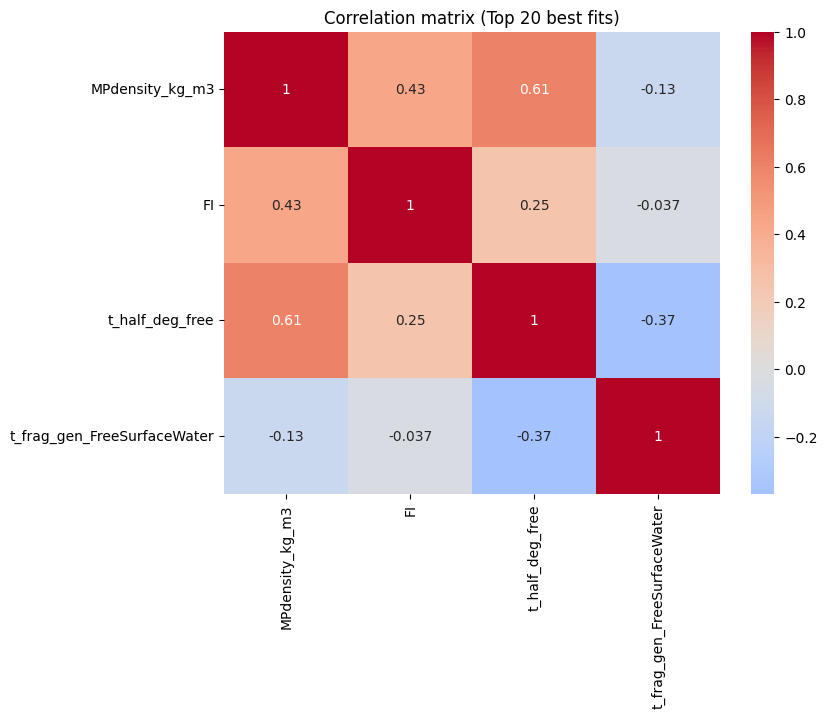

Running Monte Carlo analysis for article: FP all | Scheurer
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3524.33 cases/s]

Simulation complete! Runtime: 0:01:02.985278
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:19<00:44,  3.18s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4389.41 cases/s]

Simulation complete! Runtime: 0:01:03.090559


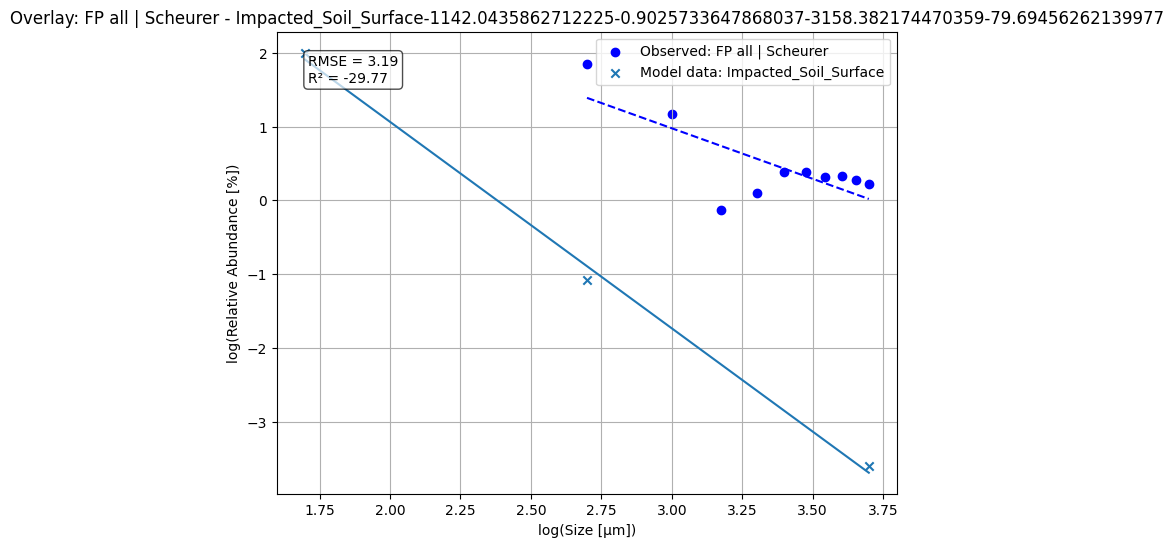

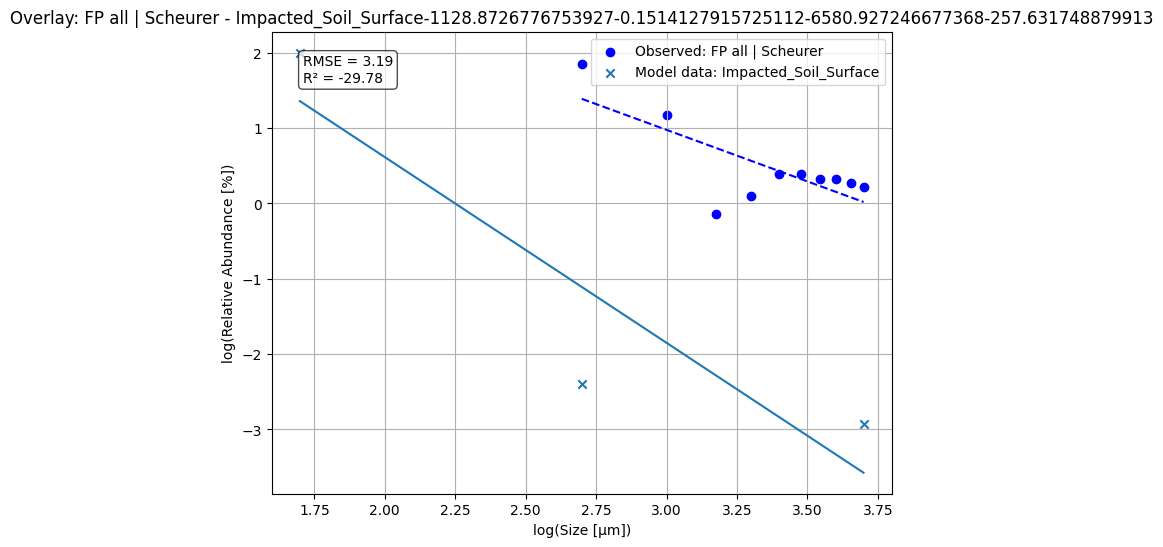

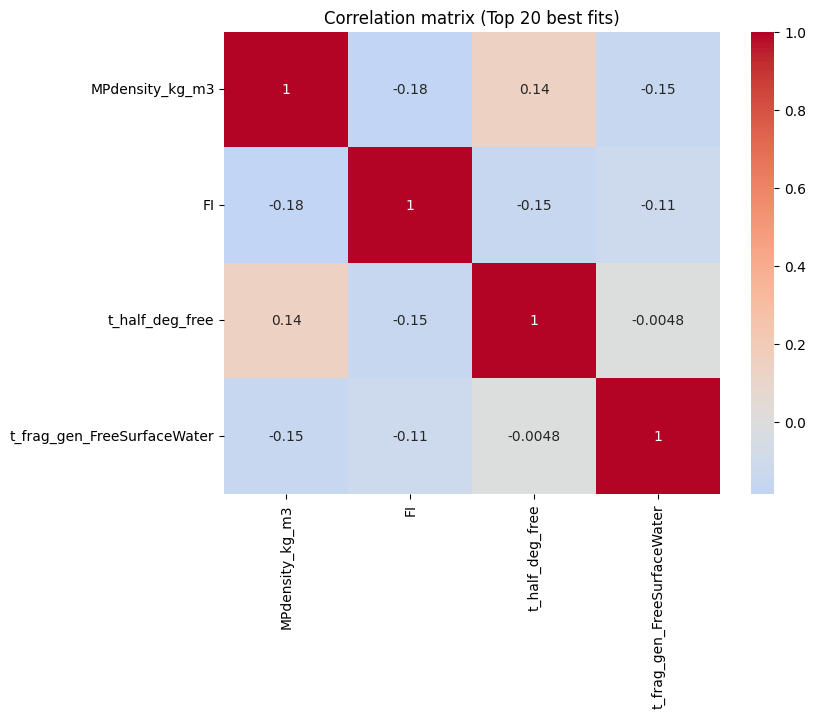

Running Monte Carlo analysis for article: Sea Surface Fragments | Song
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5003.05 cases/s]

Simulation complete! Runtime: 0:01:03.336385
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3623.59 cases/s]

Simulation complete! Runtime: 0:01:12.660914
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4958.10 cases/s]

Simulation complete! Runtime: 0:01:02.046143
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4370.66 cases/s]

Simulation complete! Runtime: 0:01:02.765782


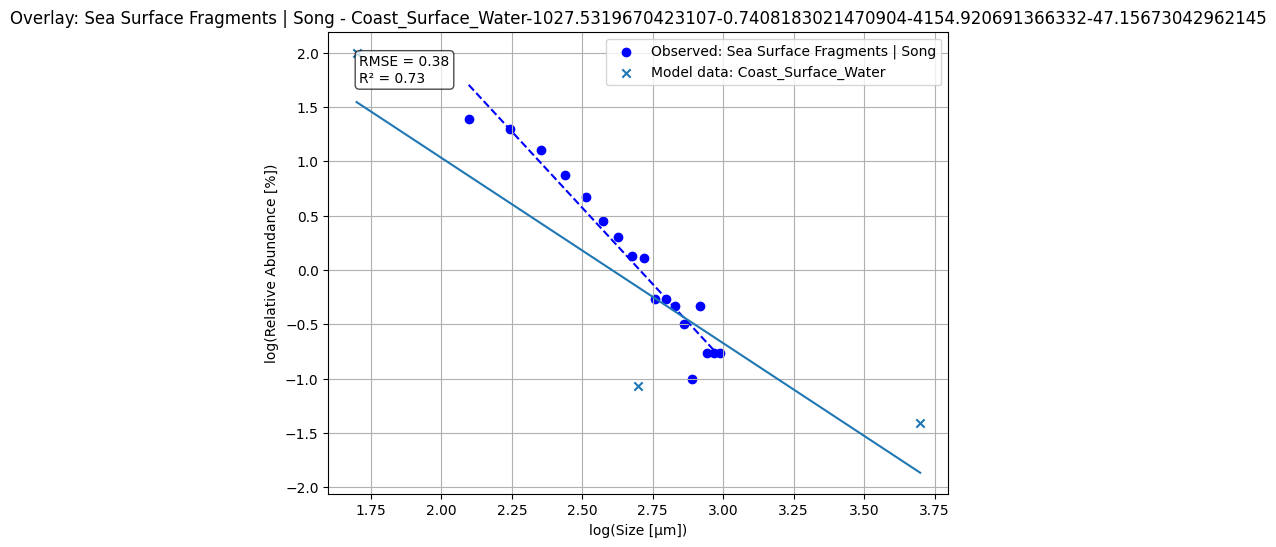

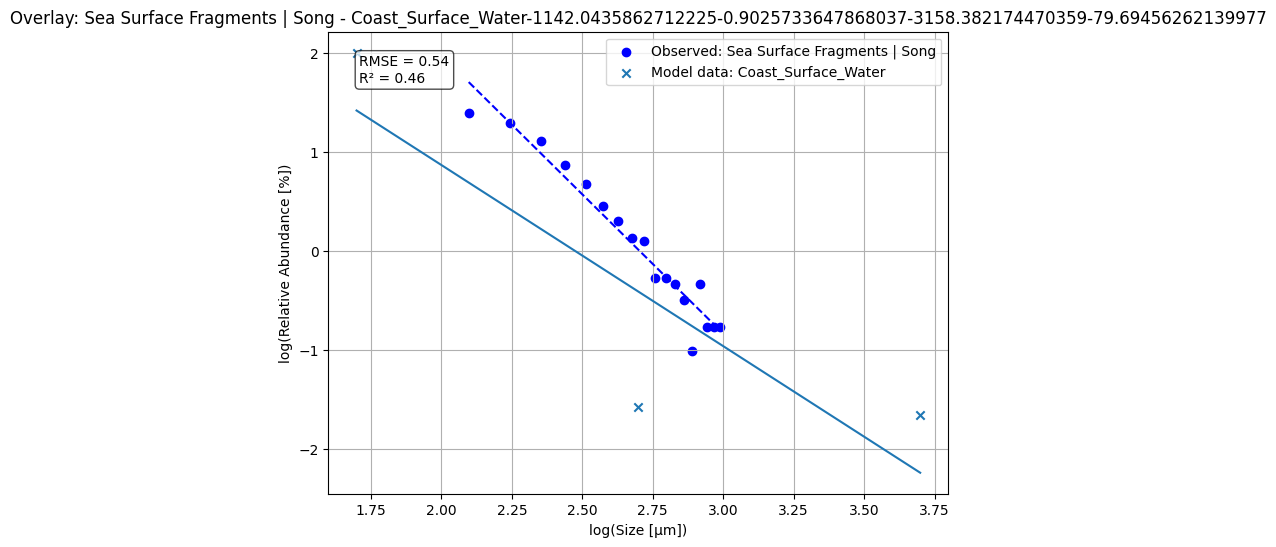

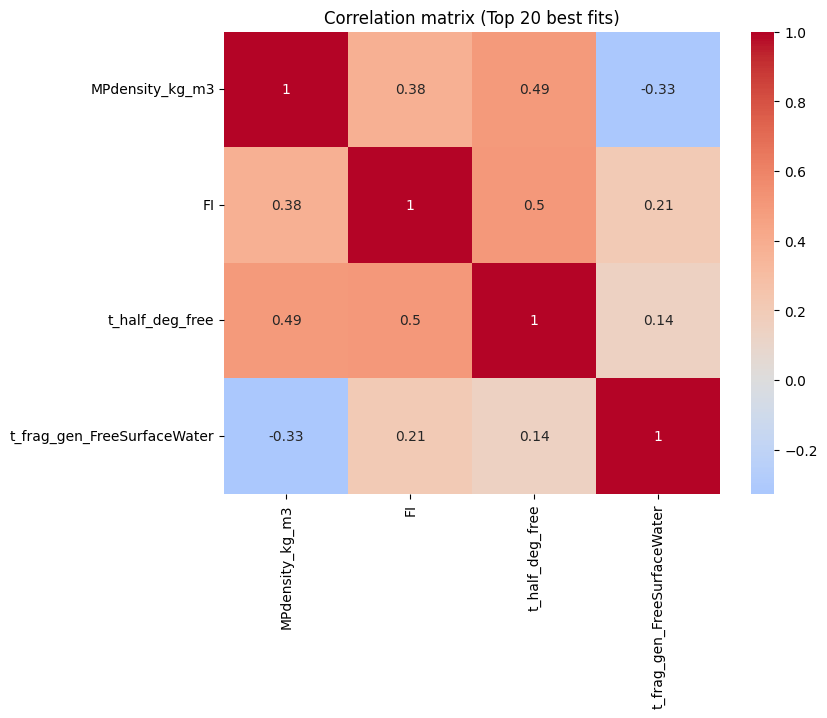

Running Monte Carlo analysis for article: Sea Surface Fibers | Song
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6621.89 cases/s]

Simulation complete! Runtime: 0:01:04.294293
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4441.00 cases/s]

Simulation complete! Runtime: 0:01:08.604103
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5698.40 cases/s]

Simulation complete! Runtime: 0:01:07.294478
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3898.96 cases/s]

Simulation complete! Runtime: 0:01:03.490175


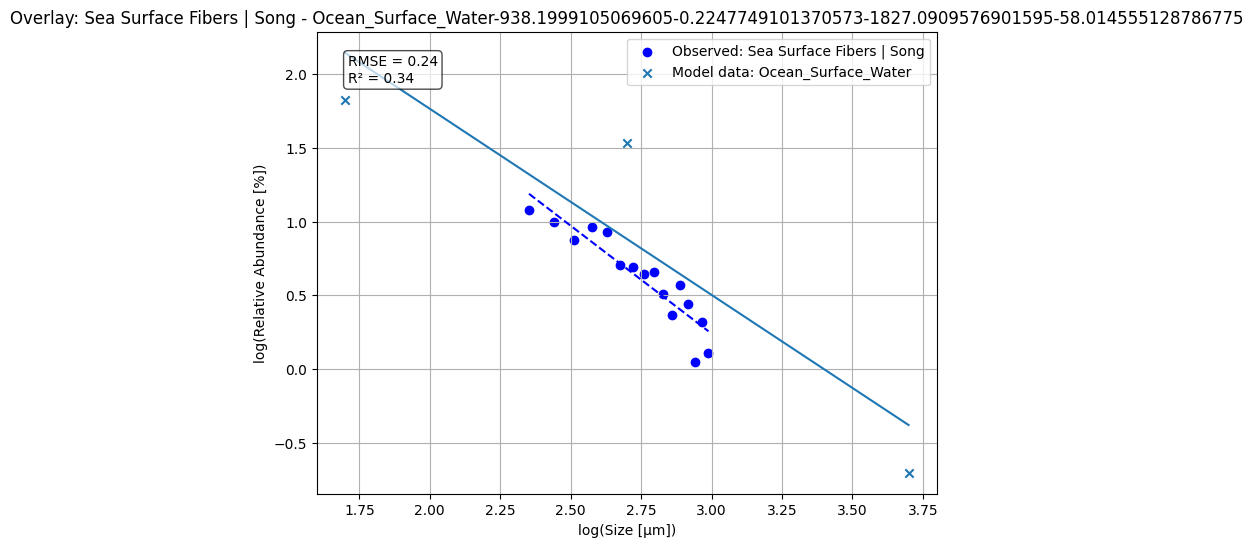

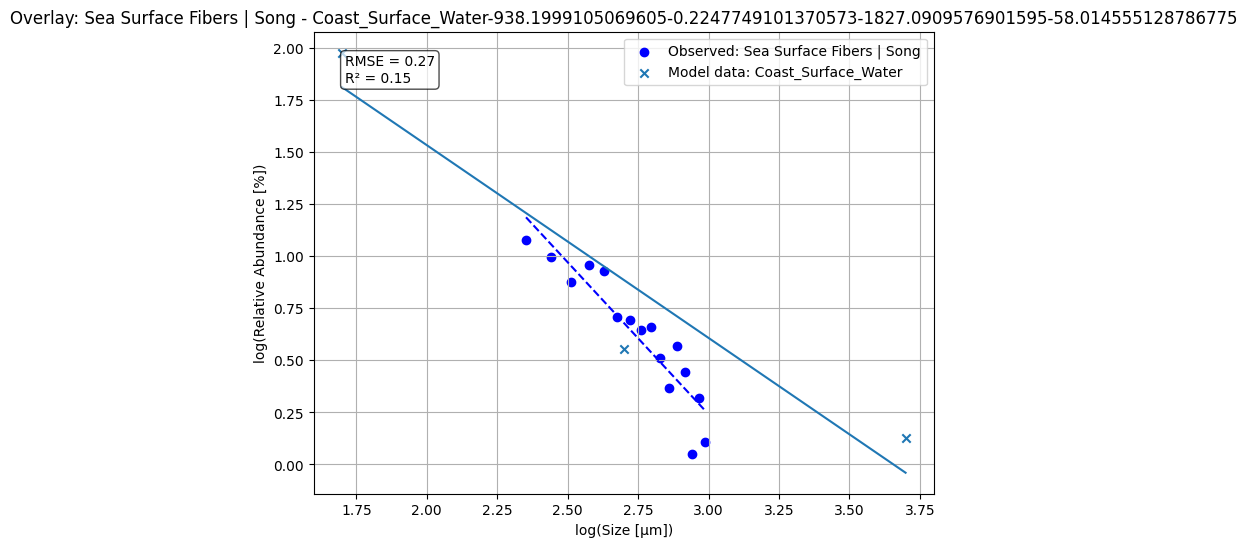

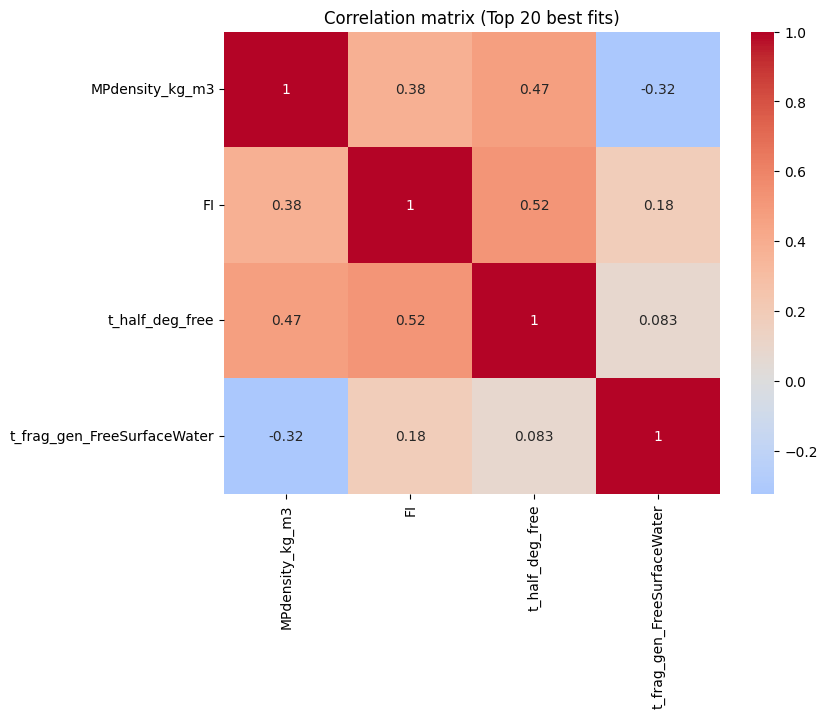

Running Monte Carlo analysis for article: Sea Surface all | Zhang
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3329.34 cases/s]

Simulation complete! Runtime: 0:01:04.507434
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6644.44 cases/s]

Simulation complete! Runtime: 0:01:03.529143
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:01:00.345490
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 11371.30 cases/s]

Simulation complete! Runtime: 0:00:50.569315


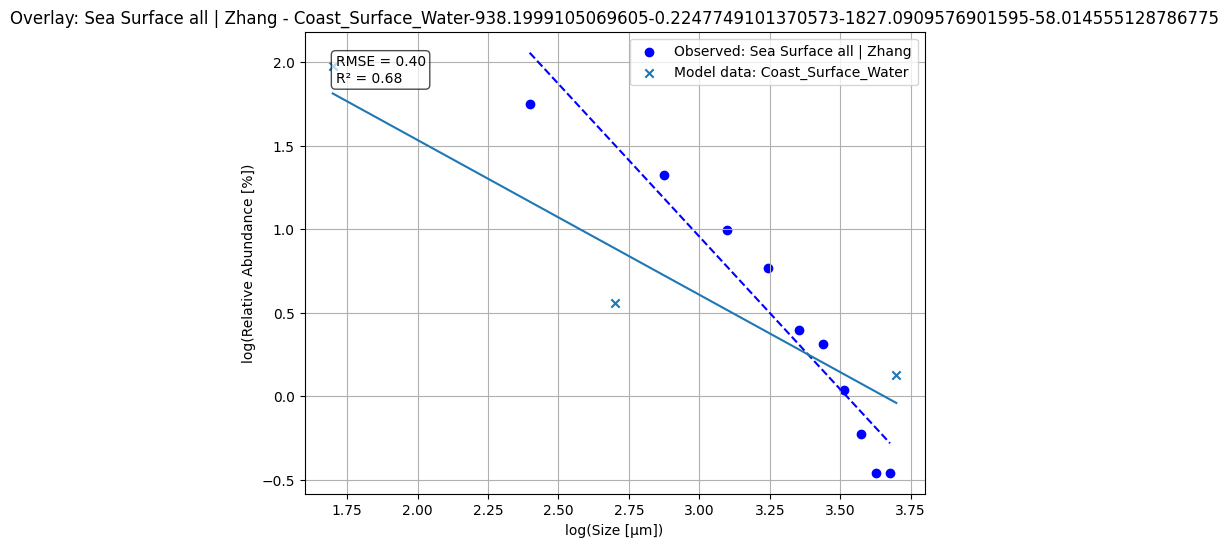

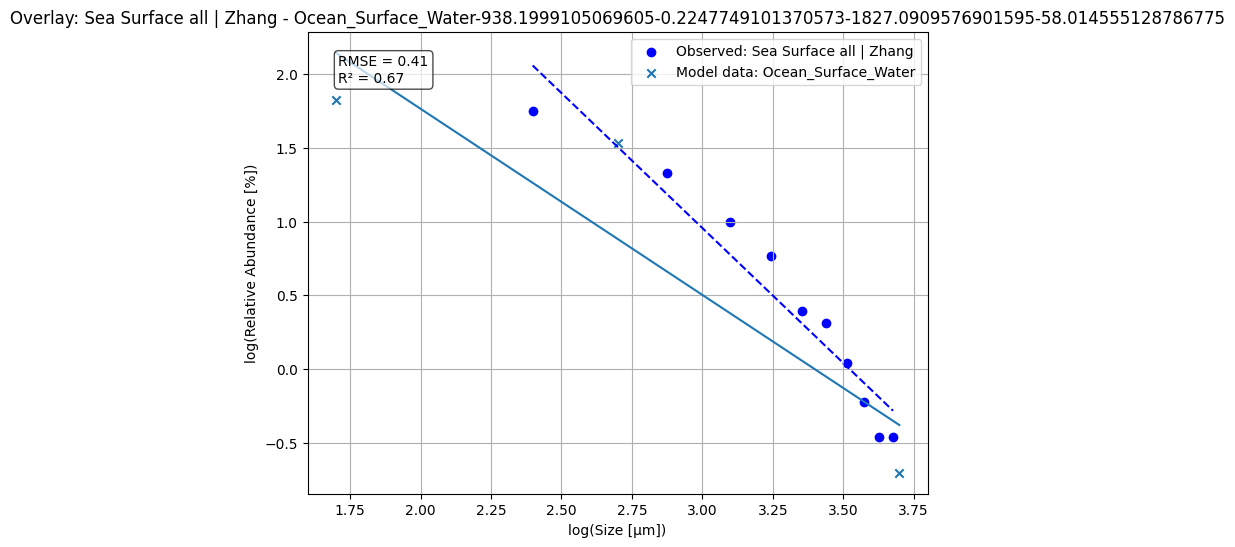

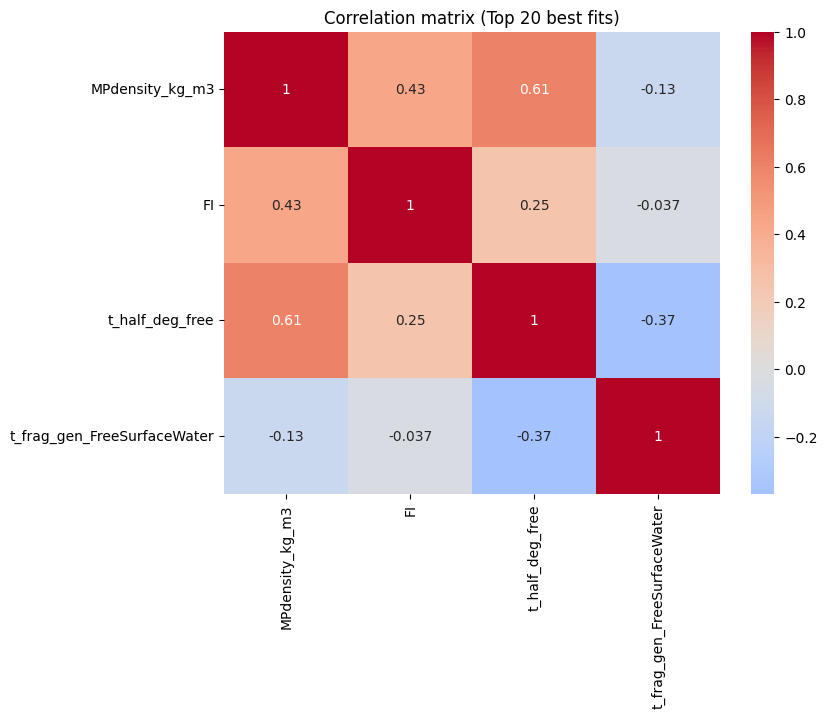

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results

MC_simulations_results_all={}
for art in overlay_emission_scenarios.keys():
    print(f"Running Monte Carlo analysis for article: {art}")
    MC_simulations_results=[]
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        
        
        #Run Monte Carlo analysis for each emission scenario and targer compartment
        for comp_T in overlay_compartments_mapping[art]:
            emission_comp=comp
            target_comp=comp_T
            sim= run_mc_analysis_paper(
            base_config=config_data,
            base_data=data_data,
            param_distributions=param_distributions,
            n_cases=20,art=art,emission_comp=emission_comp,target_comp=target_comp
        )
        
            # Convert sim results to dataframe
            df_MC_results = sim_to_dataframe(sim)
            
            
            MC_simulations_results.append(df_MC_results)
    MC_simulations_results = pd.concat(MC_simulations_results, ignore_index=True)
    input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]
    tidy_mc_results=reshape_mc_results(MC_simulations_results, input_params, art)
    results_sorted_art = tidy_mc_results.sort_values("RMSE", ascending=True)
    # Keep e.g. top 20 best-fitting combinations
    top_results_art = results_sorted_art.head(20)
    run_and_plot_top_results(top_results_art[0:2],data_data, config_data)
    

    # Correlation heatmap for the top results
    corr = top_results_art[0:20][["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation matrix (Top 20 best fits)")
    plt.show()
    
    
    MC_simulations_results_all[art]=top_results_art
    
    
        

In [13]:
combined_df = pd.concat(MC_simulations_results_all.values(), ignore_index=True)

In [14]:
combined_df

Case         Observed_dataset Emission_Compartment   Target_Compartment  \
0     108  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
1      68  Sea Sediment | Bergmann  Coast_Surface_Water       Sediment_Ocean   
2     100  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
3     112  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
4      72  Sea Sediment | Bergmann  Coast_Surface_Water       Sediment_Ocean   
..    ...                      ...                  ...                  ...   
355    61  Sea Surface all | Zhang   Surface_Freshwater  Ocean_Surface_Water   
356    47  Sea Surface all | Zhang   Surface_Freshwater  Coast_Surface_Water   
357    23  Sea Surface all | Zhang  Coast_Surface_Water  Ocean_Surface_Water   
358    63  Sea Surface all | Zhang   Surface_Freshwater  Ocean_Surface_Water   
359    37  Sea Surface all | Zhang  Coast_Surface_Water  Ocean_Surface_Water   

         RMSE         R2     Slope  Spearman_r  Pass_Spearman  \
0    0.306841  -0.542379 -2.655127        -1.0           True   
1    0.314419  -0.619506 -2.627525        -1.0           True   
2    0.319249  -0.669642 -2.453298        -1.0           True   
3    0.336169  -0.851313 -2.519515        -1.0           True   
4    0.342700  -0.923945 -2.492947        -1.0           True   
..        ...        ...       ...         ...            ...   
355  3.210394 -19.030002 -2.794831        -1.0           True   
356  3.554319 -23.551460 -2.733908        -1.0           True   
357  4.112485 -31.867982 -3.125205        -1.0           True   
358  4.395308 -36.544219 -3.319479        -1.0           True   
359  4.651851 -41.054845 -3.557464        -1.0           True   

     MPdensity_kg_m3        FI  t_half_deg_free  t_frag_gen_FreeSurfaceWater  
0        1334.859380  0.269348      2665.785177                    31.280483  
1        1334.859380  0.269348      2665.785177                    31.280483  
2        1223.294660  0.054891      6510.335737                    18.298327  
3        1170.689441  0.163532     10975.160488                    41.971349  
4        1170.689441  0.163532     10975.160488                    41.971349  
..               ...       ...              ...                          ...  
355      1027.531967  0.740818      4154.920691                    47.156730  
356      1302.585757  0.539578      9481.499850                    12.343862  
357      1142.043586  0.902573      3158.382174                    79.694563  
358      1142.043586  0.902573      3158.382174                    79.694563  
359      1052.671922  0.811533      3073.415520                    14.554329  

[360 rows x 13 columns]

In [17]:
# Save results to csv
combined_df.to_csv("UTOPIA_paper_results.csv", index=False)

Top 20 best fitting results for each observed dataset

In [4]:
combined_results_shorted=combined_df.sort_values("RMSE", ascending=True)
combined_results_shorted

NameError: name 'combined_df' is not defined

In [ ]:

from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results
run_and_plot_top_results(combined_results_shorted[0:2],data_data, config_data)

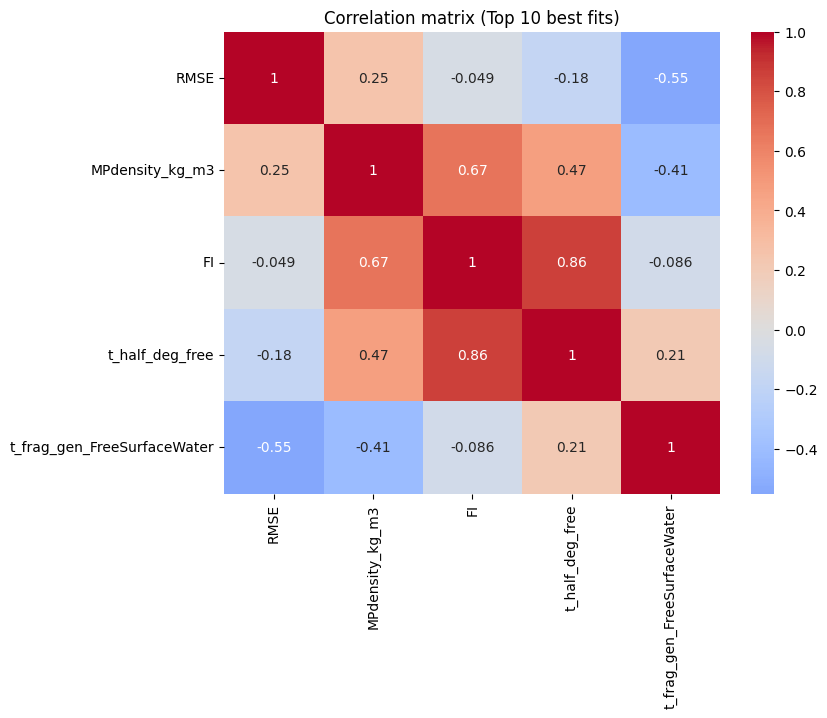

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = combined_results_shorted[0:20][["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 20 best fits)")
plt.show()

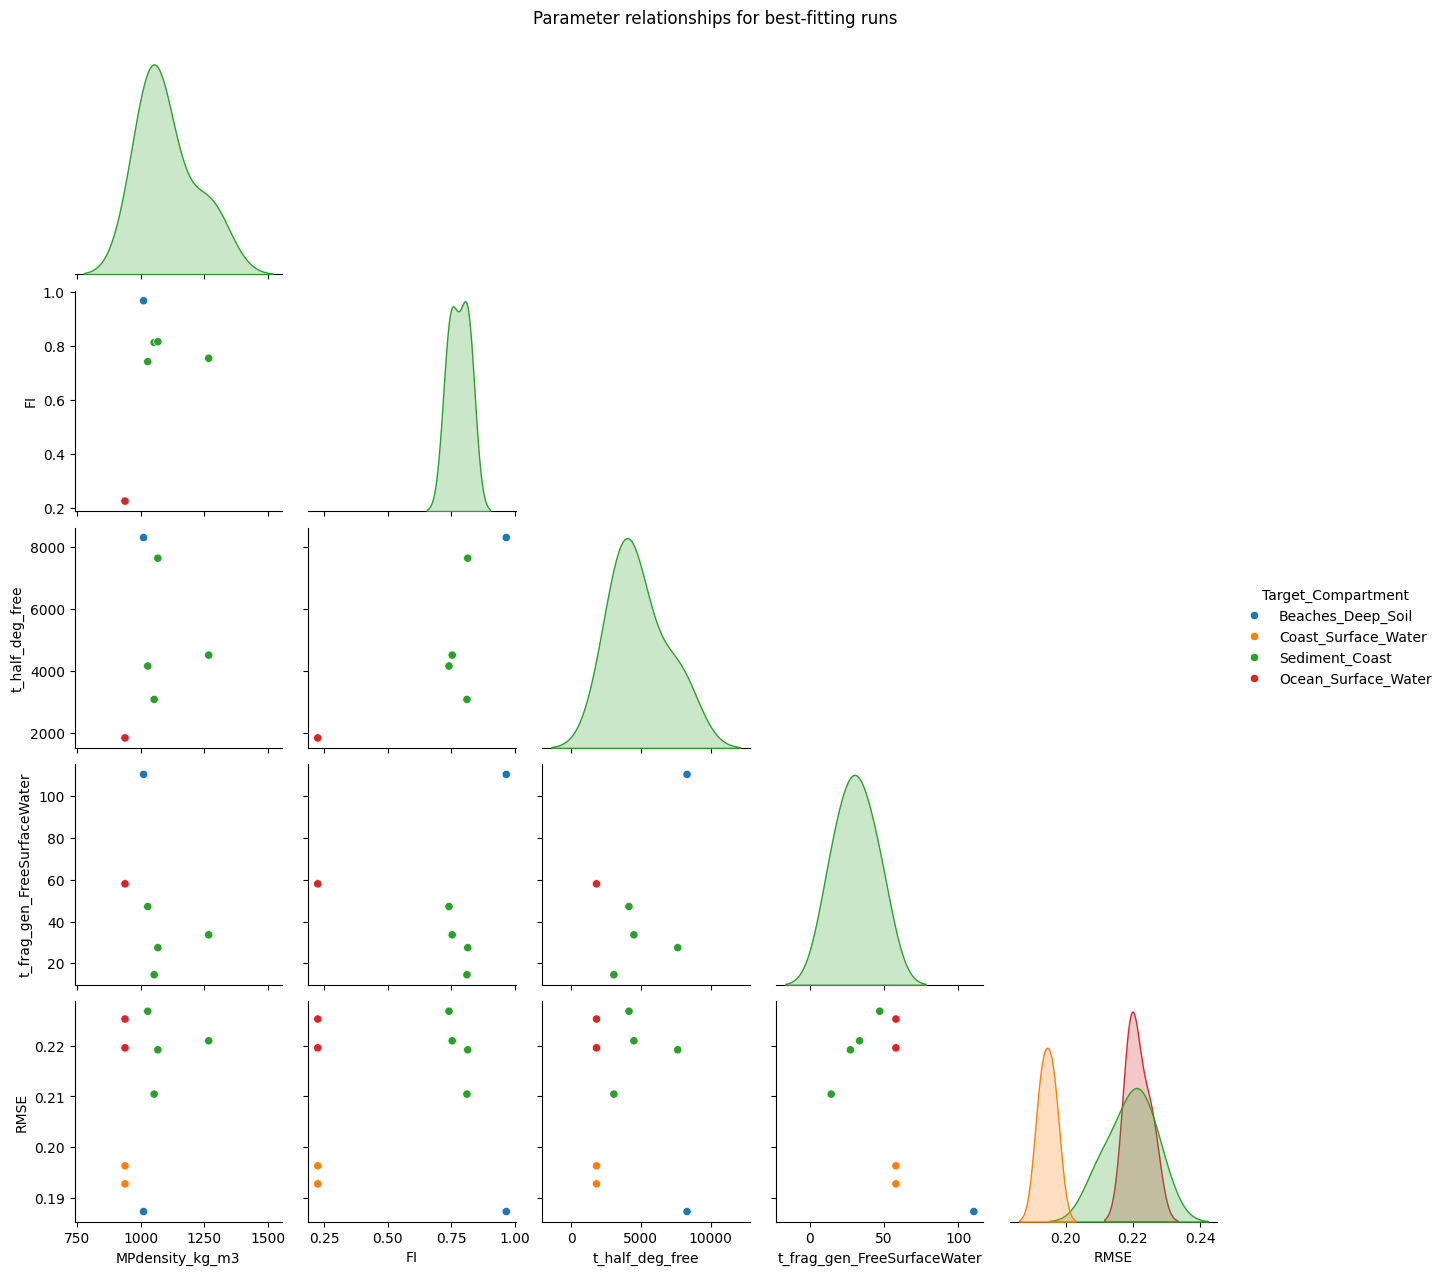

In [46]:
# Pair-wise relationships for the top results
sns.pairplot(
    combined_results_shorted[0:10],
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()

 After the model has ben run recover results from csv and load them again

In [5]:
# Read data from CSV if needed
combined_results = pd.read_csv("UTOPIA_paper_results.csv")
df=combined_results.copy()

In [6]:
combined_results_shorted=df.sort_values("RMSE", ascending=True)

In [8]:
combined_results_shorted[0:20]

Case               Observed_dataset   Emission_Compartment  \
220     6     Sea Surface all | Isobe L2     Surface_Freshwater   
240     6     Sea Surface all | Isobe L3     Surface_Freshwater   
120    97     Fragments in sediment | Eo     Surface_Freshwater   
121    85     Fragments in sediment | Eo     Surface_Freshwater   
260    26     Sea Surface all | Isobe L4     Surface_Freshwater   
200    26     Sea Surface all | Isobe L1     Surface_Freshwater   
122    95     Fragments in sediment | Eo     Surface_Freshwater   
241    66     Sea Surface all | Isobe L3    Coast_Surface_Water   
123    81     Fragments in sediment | Eo     Surface_Freshwater   
261     6     Sea Surface all | Isobe L4     Surface_Freshwater   
124    91     Fragments in sediment | Eo     Surface_Freshwater   
20     41          Sea Surface all | Cai    Coast_Surface_Water   
320    66      Sea Surface Fibers | Song     Surface_Freshwater   
140    83        Fibers in sediment | Eo     Surface_Freshwater   
221    66     Sea Surface all | Isobe L2    Coast_Surface_Water   
242    26     Sea Surface all | Isobe L3     Surface_Freshwater   
201     6     Sea Surface all | Isobe L1     Surface_Freshwater   
321    46      Sea Surface Fibers | Song     Surface_Freshwater   
80     46        Fragments in water | Eo     Surface_Freshwater   
180    66  Fresh water sediments | Imhof  Impacted_Soil_Surface   

      Target_Compartment      RMSE        R2     Slope  Spearman_r  \
220  Coast_Surface_Water  0.192740  0.540131 -0.926349        -1.0   
240  Coast_Surface_Water  0.196303  0.512105 -0.926349        -1.0   
120       Sediment_Coast  0.210465  0.830557 -1.757989        -1.0   
121       Sediment_Coast  0.219214  0.816177 -1.605927        -1.0   
260  Ocean_Surface_Water  0.219473  0.496743 -1.260351        -1.0   
200  Ocean_Surface_Water  0.219608  0.717863 -1.260351        -1.0   
122       Sediment_Coast  0.220993  0.813182 -1.619336        -1.0   
241  Ocean_Surface_Water  0.225292  0.357365 -0.761238        -1.0   
123       Sediment_Coast  0.226836  0.803171 -1.555892        -1.0   
261  Coast_Surface_Water  0.228836  0.452885 -0.926349        -1.0   
124       Sediment_Coast  0.240624  0.778517 -1.524742        -1.0   
20   Coast_Surface_Water  0.241146  0.833343 -1.488332        -1.0   
320  Ocean_Surface_Water  0.242450  0.341708 -1.260351        -1.0   
140       Sediment_Coast  0.246943 -0.238814 -1.236710        -1.0   
221  Ocean_Surface_Water  0.248879  0.233221 -0.761238        -1.0   
242  Ocean_Surface_Water  0.272301  0.061204 -1.260351        -1.0   
201  Coast_Surface_Water  0.273270  0.563134 -0.926349        -1.0   
321  Coast_Surface_Water  0.274691  0.154986 -0.926349        -1.0   
80       Bulk_Freshwater  0.280510  0.837037 -1.644561        -1.0   
180   Surface_Freshwater  0.284774  0.219064 -2.776208        -1.0   

     Pass_Spearman  MPdensity_kg_m3        FI  t_half_deg_free  \
220           True       938.199911  0.224775      1827.090958   
240           True       938.199911  0.224775      1827.090958   
120           True      1052.671922  0.811533      3073.415520   
121           True      1067.147583  0.814583      7649.971822   
260           True       938.199911  0.224775      1827.090958   
200           True       938.199911  0.224775      1827.090958   
122           True      1266.860208  0.753409      4509.321025   
241           True       938.199911  0.224775      1827.090958   
123           True      1027.531967  0.740818      4154.920691   
261           True       938.199911  0.224775      1827.090958   
124           True      1193.888212  0.679468      7014.614289   
20            True      1027.531967  0.740818      4154.920691   
320           True       938.199911  0.224775      1827.090958   
140           True      1142.043586  0.902573      3158.382174   
221           True       938.199911  0.224775      1827.090958   
242           True       938.199911  0.224775      1827.090958   
201 

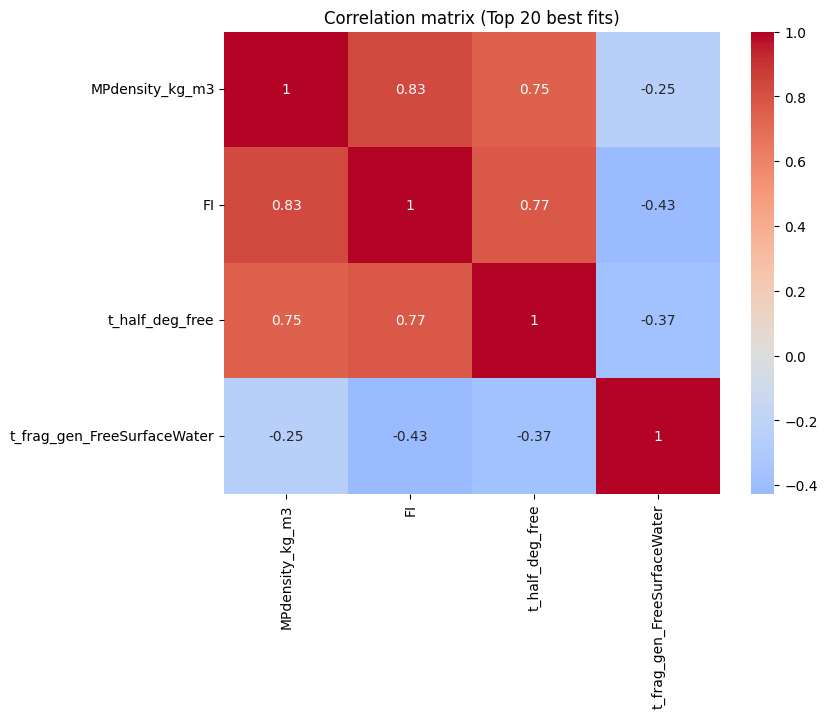

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = combined_results_shorted[0:19][["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 20 best fits)")
plt.show()

CONTINUE HERE

In [ ]:
# Write up conclusions and next steps

# Best fits corresponds to 2 archetypical types of plastic:
# 1. Low density plastic (LDP) provides best fits to the monitoring data when framgentation index is low (more erosive fragmentation) and and disintegration half-life is short. Fragmentation timescale seems to not play a significant role according to the correlation matrix.
# 2. High density plastic (HDP), provides best fits when fragmentation index is high (more explosive fragmentation) and disintegration half-life is long. Fragmentation timescale seems to not play a significant role according to the correlation matrix.

# We will run scenarios for the two archetipycal plastics and compare results to the articles data to plot best fits against observed data.

In [ ]:
# SET UP SCENARIOS FOR THE TWO ARCHETYPICAL PLASTICS
# 1. Low density plastic (LDP) provides best fits to the monitoring data when framgentation index is low (more erosive fragmentation) and and disintegration half-life is short. Fragmentation timescale seems to not play a significant role according to the correlation matrix.

In [10]:
# Set up scenario simulation for LDP and HDP
from utopia.utopia import utopiaModel
# Define modifications (follow the structure providede in the default configuration data (data_data))
modifications = {
    "MPdensity_kg_m3": 900,
    "MP_composition": "LDP",
    'FI': 0.2,
    "t_half_deg_free": 3000,
    "t_frag_gen_FreeSurfaceWater": 32
}


In [ ]:
LDP_data=data_data.copy()
LDP_data["MPdensity_kg_m3"]= modifications["MPdensity_kg_m3"]
LDP_data["MP_composition"]= modifications["MP_composition"]
LDP_data["FI"]= modifications["FI"]
LDP_data["t_half_deg_free"]= modifications["t_half_deg_free"]
LDP_data["t_frag_gen_FreeSurfaceWater"]= modifications["t_frag_gen_FreeSurfaceWater"]    
LDP_data

{'MPdensity_kg_m3': 900,
 'MP_composition': 'LDP',
 'shape': 'sphere',
 'MP_form': 'freeMP',
 'FI': 0.2,
 't_half_deg_free': 3000,
 'heter_deg_factor': 10,
 'biof_deg_factor': 0.5,
 'factor_deepWater_soilSurface': 10,
 'factor_sediment': 100,
 't_frag_gen_FreeSurfaceWater': 32,
 'biof_frag_factor': 2,
 'heter_frag_factor': 100,
 'emiss_dict_g_s': {'Ocean_Surface_Water': {'a': 0,
   'b': 0,
   'c': 0,
   'd': 0,
   'e': 100},
  'Ocean_Mixed_Water': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Ocean_Column_Water': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Coast_Surface_Water': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Coast_Column_Water': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Surface_Freshwater': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Bulk_Freshwater': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Sediment_Freshwater': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Sediment_Ocean': {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0},
  'Sediment_Coast': {'a': 0, 'b': 0, 'c': 0, 'd':

In [13]:
import pandas as pd
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from scipy.stats import spearmanr
from utopia.monte_carlo.montecarlo_analysis_paper import extract_log_rel_abundance


# Run the model for each emission scenario and target compartment
LDP_simulations_results_all={}
for art in overlay_emission_scenarios.keys():
    print(f"Running Monte Carlo analysis for article: {art}")
    LDP_simulations_results=[]
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        LDP_data["emiss_dict_g_s"]= set_emission(LDP_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        for comp_T in overlay_compartments_mapping[art]:
            emission_comp=comp
            target_comp=comp_T
            model = utopiaModel(config=config_data, data=LDP_data)
            model.run()
            processor = ResultsProcessor(model)  # Custom processor to handle results
            processor.estimate_flows()
            processor.generate_flows_dict()
            processor.process_results()
            processor.extract_results_by_compartment()
            df = processor.results_by_comp
            df2 = processor.Results_extended
            # processor.estimate_exposure_indicators()

            # Process model outputs into log-relative abundances per size fraction and compare with observed data
            observed_file = "../src/utopia/data/observed_data_long.xlsx"

            observed_df = pd.read_excel(observed_file)

            observed_df = observed_df.rename(columns={
            "dataset identifier": "Dataset",
            "Article name": "Article",
            "log‑transformed size": "log_Size",
            "log‑transformed abundance": "log_Abundance",
        }
    )
            obs_subset = observed_df[observed_df["Article"] == art]
            x_obs_all = obs_subset["log_Size"].astype(float).values
            y_obs_all = obs_subset["log_Abundance"].astype(float).values

            if len(x_obs_all) > 2:
                slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
            else:
                slope_obs, intercept_obs = np.nan, np.nan

            result = {}

            # comp_relative_abundance_resultsaccording to target compartment set in the input parameters

            # Exclude size bins that are not withing the observed data range (0.5 and 5 um)
            excluded_sizes = [0.5, 5]
            filtered_Results = df2[~df2["Size_Fraction_um"].isin(excluded_sizes)]
            rel_abun = extract_log_rel_abundance(
                filtered_Results,
                compartment=target_comp,
                value_col="number_of_particles",
            )

            if rel_abun.empty:
                # fill with NaNs
                result.update(
                    {
                        "Spearman_r": np.nan,
                        "Spearman_p": np.nan,
                        "Pass_Spearman": False,
                        "RMSE": np.nan,
                        "R_squared": np.nan,
                        "Model_slope": np.nan,
                        "Model_intercept": np.nan,
                        "Target_compartment": target_comp,
                        "Emission_compartment": emission_comp,
                    }
                )

            else:

                x_mod_all = rel_abun["log_size"].values
                y_mod_all = rel_abun["log_rel_abundance"].values

                # Spearman correlation
                r_value, p_value = spearmanr(x_mod_all, y_mod_all)

                spearman_threshold = -1

                # Initialize metrics
                rmse, r2, slope_mod, intercept_mod = np.nan, np.nan, np.nan, np.nan
                if np.isnan(r_value):
                    pass_spearman = False
                elif (r_value) == spearman_threshold:
                    pass_spearman = True
                else:
                    pass_spearman = False

                # Compute RMSE, R², slope, intercept only if threshold passed

                if pass_spearman == True and len(x_mod_all) > 2 and len(x_obs_all) > 2:
                    slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)

                    # Align with observed range
                    x_min = max(x_obs_all.min(), x_mod_all.min())
                    x_max = min(x_obs_all.max(), x_mod_all.max())
                    mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
                    x_obs_filt = x_obs_all[mask_obs]
                    y_obs_filt = y_obs_all[mask_obs]

                    if len(x_obs_filt) > 2:
                        pred_y = slope_mod * x_obs_filt + intercept_mod
                        ss_res = np.sum((y_obs_filt - pred_y) ** 2)
                        ss_tot = np.sum((y_obs_filt - np.mean(y_obs_filt)) ** 2)
                        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
                        rmse = np.sqrt(ss_res / len(x_obs_filt))

                        # Plot observed vs model with metrics only if spearman test is true
                        # plot_obs_vs_model_with_metrics_True(
                        #     x_obs_all,
                        #     y_obs_all,
                        #     x_mod_all,
                        #     y_mod_all,
                        #     comp,
                        #     art,
                        #     rmse,
                        #     r2,
                        #     MP_density=model.MPdensity_kg_m3,
                        #     FI=model.FI,
                        #     t_half_deg=model.t_half_deg_free,
                        #     t_frag=model.t_frag_gen_FreeSurfaceWater,
                        # )

                        # Store all metrics in result dict
                        result.update(
                            {
                                "Spearman_r": r_value,
                                "Spearman_p": p_value,
                                "Pass_Spearman": pass_spearman,
                                "RMSE": rmse,
                                "R_squared": r2,
                                "Model_slope": slope_mod,
                                "Model_intercept": intercept_mod,
                                "Target_compartment": target_comp,
                                "Emission_compartment": emission_comp,
                            }
                        )
                    else:
                        # If not enough points to compute metrics, store NaNs
                        result.update(
                            {
                                "Spearman_r": np.nan,
                                "Spearman_p": np.nan,
                                "Pass_Spearman": False,
                                "RMSE": np.nan,
                                "R_squared": np.nan,
                                "Model_slope": np.nan,
                                "Model_intercept": np.nan,
                                "Target_compartment": target_comp,
                                "Emission_compartment": emission_comp,
                            }
                        )
                else:
                    # Store all metrics in result dict
                    result.update(
                        {
                            "Spearman_r": np.nan,
                            "Spearman_p": np.nan,
                            "Pass_Spearman": False,
                            "RMSE": np.nan,
                            "R_squared": np.nan,
                            "Model_slope": np.nan,
                            "Model_intercept": np.nan,
                            "Target_compartment": target_comp,
                            "Emission_compartment": emission_comp,
                        }
                    )
            LDP_simulations_results.append(result)
    LDP_simulations_results_all[art]=LDP_simulations_results    
                

            
            

Running Monte Carlo analysis for article: Sea Sediment | Bergmann


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWar

Running Monte Carlo analysis for article: Sea Surface all | Cai
Running Monte Carlo analysis for article: Sea Surface Fragments | Enders
Running Monte Carlo analysis for article: Sea Surface Fibers | Enders
Running Monte Carlo analysis for article: Fragments in water | Eo
Running Monte Carlo analysis for article: Fibers in water | Eo
Running Monte Carlo analysis for article: Fragments in sediment | Eo


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWar

Running Monte Carlo analysis for article: Fibers in sediment | Eo


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWar

Running Monte Carlo analysis for article: Sea Surface all | Erni-Cassola
Running Monte Carlo analysis for article: Fresh water sediments | Imhof
Running Monte Carlo analysis for article: Sea Surface all | Isobe L1
Running Monte Carlo analysis for article: Sea Surface all | Isobe L2
Running Monte Carlo analysis for article: Sea Surface all | Isobe L3
Running Monte Carlo analysis for article: Sea Surface all | Isobe L4
Running Monte Carlo analysis for article: FP all | Scheurer


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running Monte Carlo analysis for article: Sea Surface Fragments | Song
Running Monte Carlo analysis for article: Sea Surface Fibers | Song
Running Monte Carlo analysis for article: Sea Surface all | Zhang


In [ ]:
### CONTINUE HERE. nEED TO TTANSFORM DICTIONARIES TO DATAFRAME AND PLOT RESULTS THAT CAN BE COMPARED TO THE OBSERVED DATA

In [14]:
LDP_simulations_results_all

{'Sea Sediment | Bergmann': [{'Spearman_r': nan,
   'Spearman_p': nan,
   'Pass_Spearman': False,
   'RMSE': nan,
   'R_squared': nan,
   'Model_slope': nan,
   'Model_intercept': nan,
   'Target_compartment': 'Sediment_Coast',
   'Emission_compartment': 'Ocean_Surface_Water'},
  {'Spearman_r': nan,
   'Spearman_p': nan,
   'Pass_Spearman': False,
   'RMSE': nan,
   'R_squared': nan,
   'Model_slope': nan,
   'Model_intercept': nan,
   'Target_compartment': 'Sediment_Ocean',
   'Emission_compartment': 'Ocean_Surface_Water'},
  {'Spearman_r': nan,
   'Spearman_p': nan,
   'Pass_Spearman': False,
   'RMSE': nan,
   'R_squared': nan,
   'Model_slope': nan,
   'Model_intercept': nan,
   'Target_compartment': 'Sediment_Coast',
   'Emission_compartment': 'Coast_Surface_Water'},
  {'Spearman_r': nan,
   'Spearman_p': nan,
   'Pass_Spearman': False,
   'RMSE': nan,
   'R_squared': nan,
   'Model_slope': nan,
   'Model_intercept': nan,
   'Target_compartment': 'Sediment_Ocean',
   'Emission_com

Can we conclude from the correlation values that best fits (lowest RMSE) are associated to lowest densities and FI values?

In [17]:
df =combined_results_shorted[0:19]
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Suppose your dataframe is df
# Identify features and target
target = 'RMSE'
numeric_features = ['MPdensity_kg_m3', 'FI', 't_half_deg_free', 't_frag_gen_FreeSurfaceWater']
#categorical_features = ['Observed_dataset', 'Emission_Compartment', 'Target_Compartment']

#X = df[numeric_features + categorical_features]
X = df[numeric_features]
y = df[target]

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        #('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


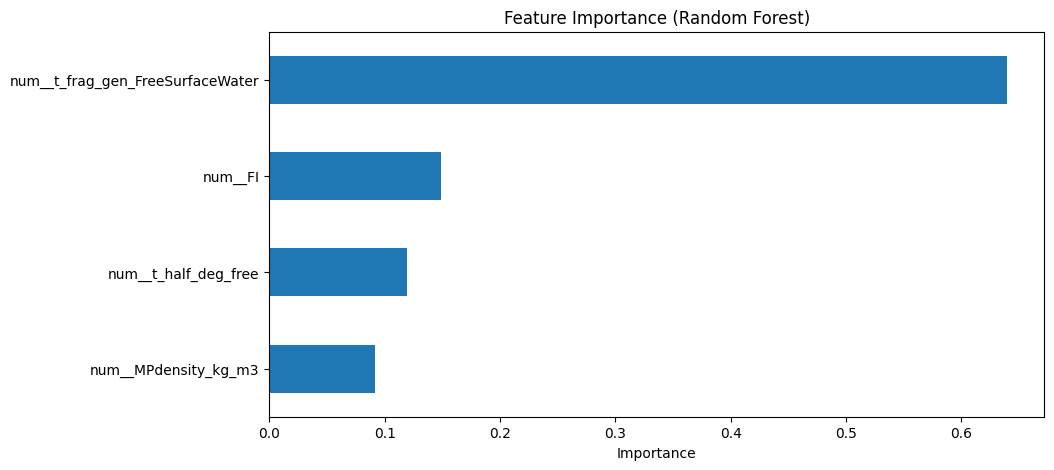

num__t_frag_gen_FreeSurfaceWater    0.639934
num__FI                             0.149061
num__t_half_deg_free                0.119103
num__MPdensity_kg_m3                0.091903
dtype: float64

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# Build pipeline
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=500, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Extract feature importances
rf = model.named_steps['rf']
feature_names = model.named_steps['preprocess'].get_feature_names_out()
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot importance
plt.figure(figsize=(10, 5))
importances[:15].plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

importances.head(10)


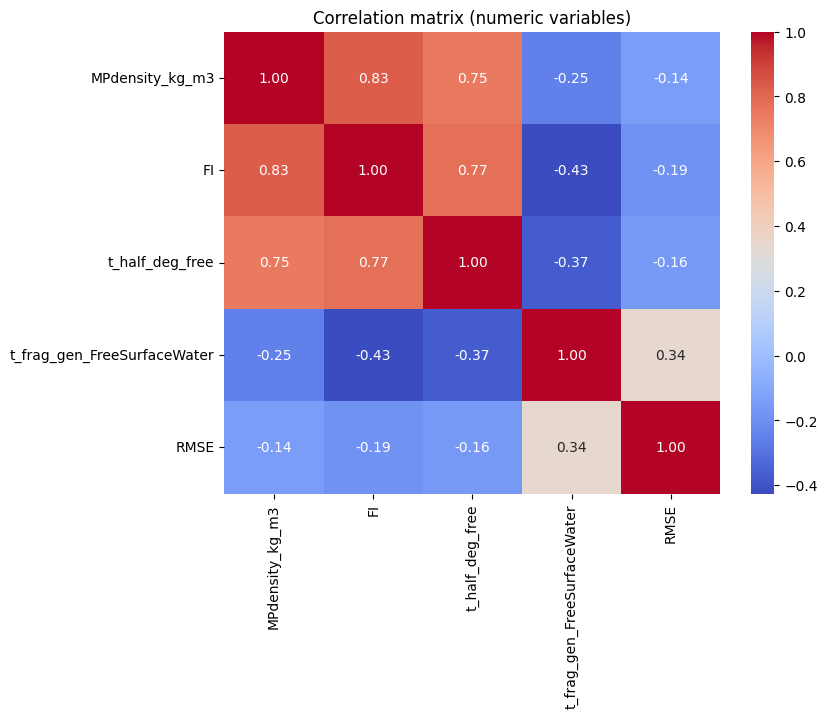

RMSE                           1.000000
t_frag_gen_FreeSurfaceWater    0.341477
MPdensity_kg_m3               -0.144032
t_half_deg_free               -0.162749
FI                            -0.191916
Name: RMSE, dtype: float64

In [19]:
import seaborn as sns
corr = df[numeric_features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix (numeric variables)")
plt.show()

corr[target].sort_values(ascending=False)


From top results run model and plot overlays with observed data

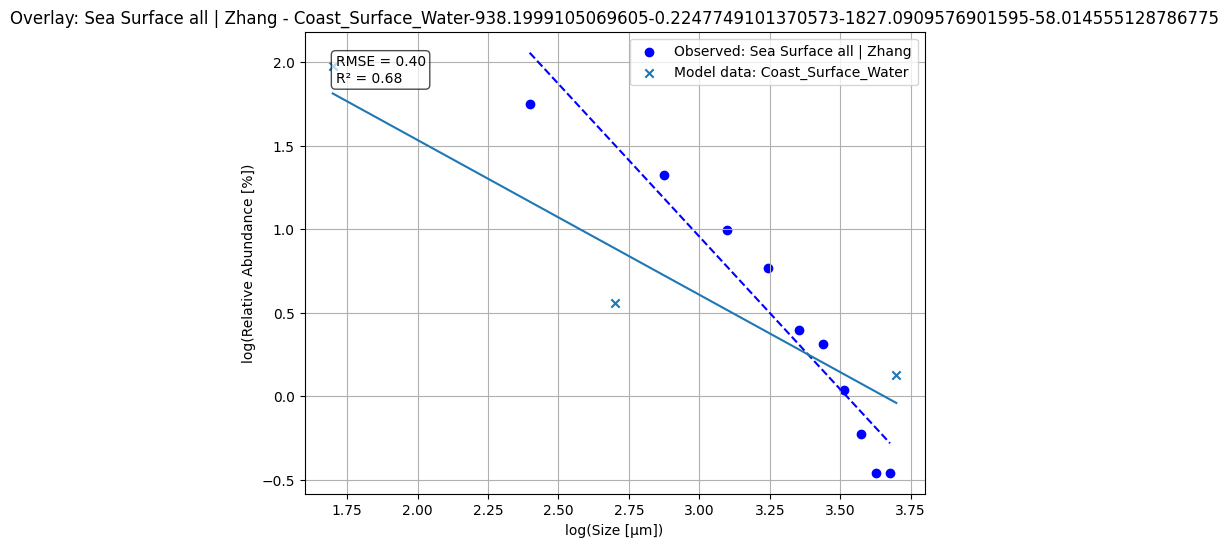

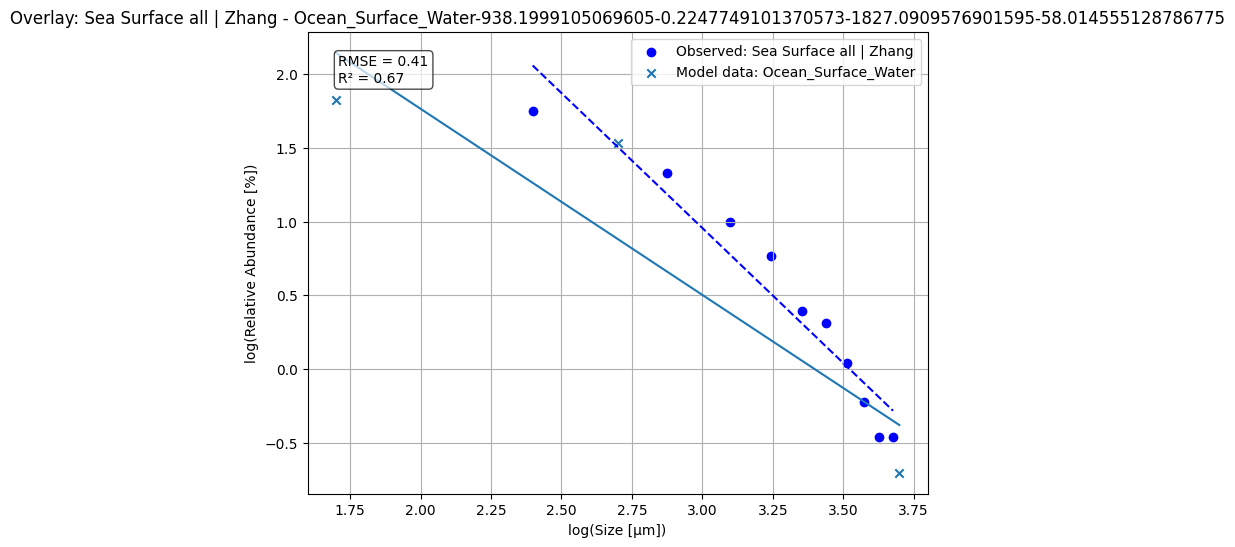

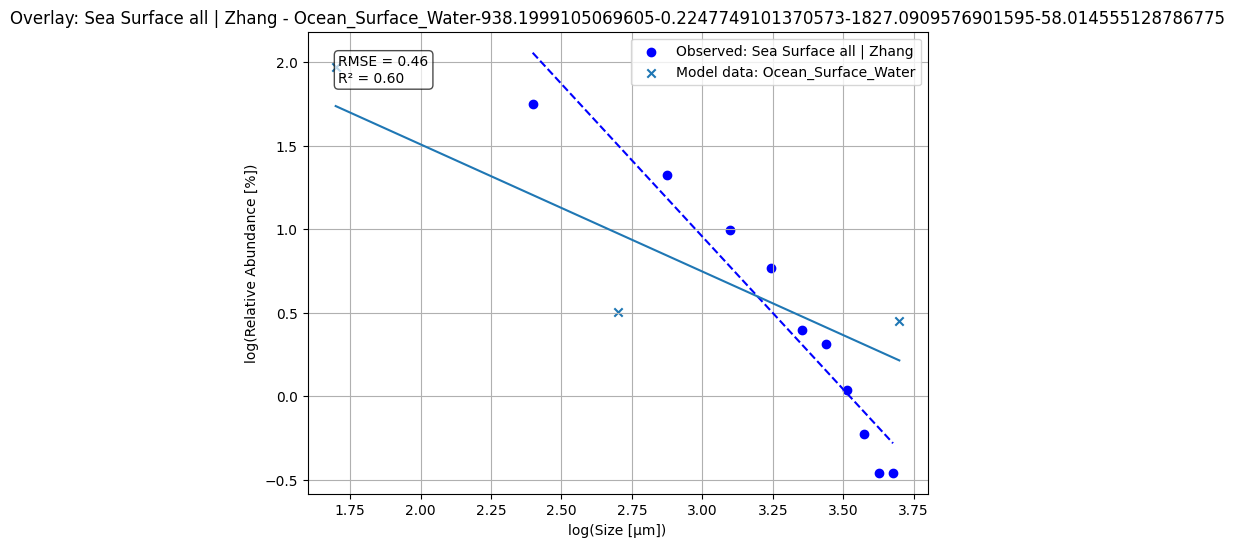

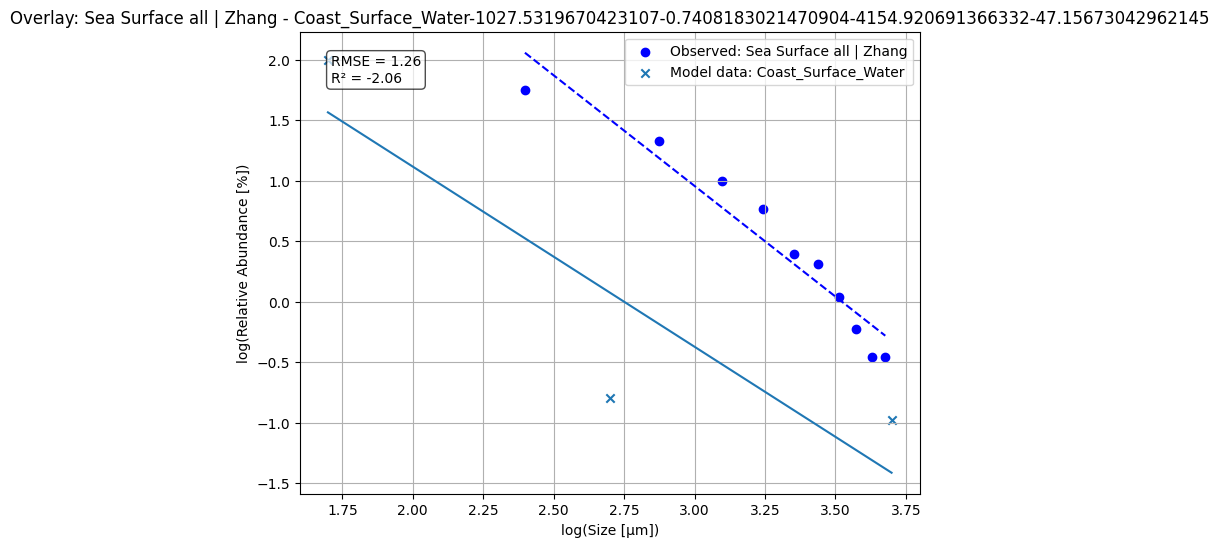

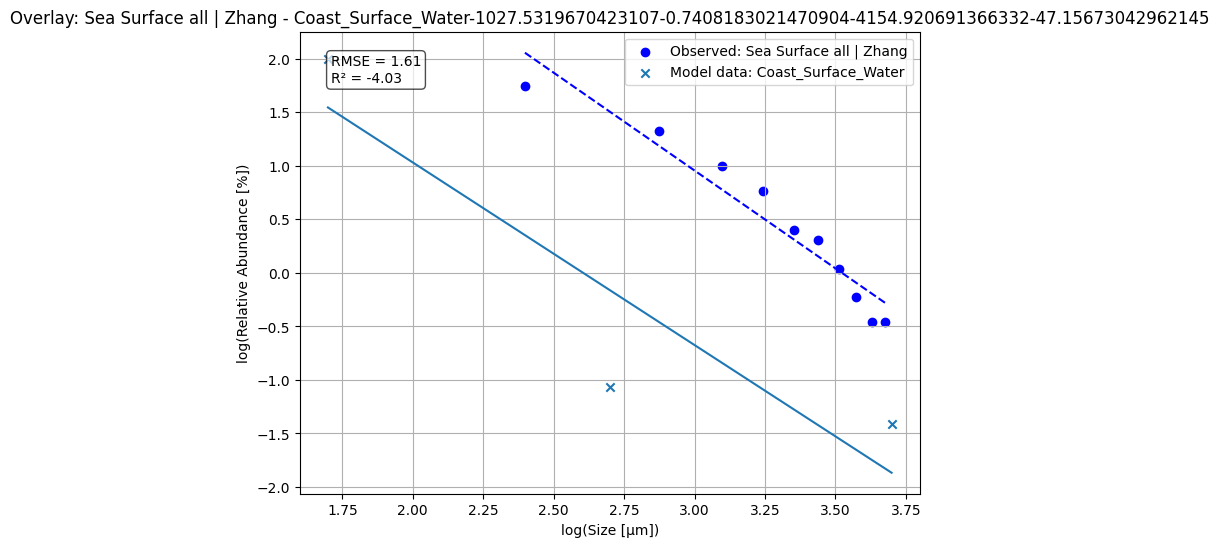

In [29]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results
run_and_plot_top_results(top_results_all[0:5],data_data, config_data)

Correlation heat maps for top results

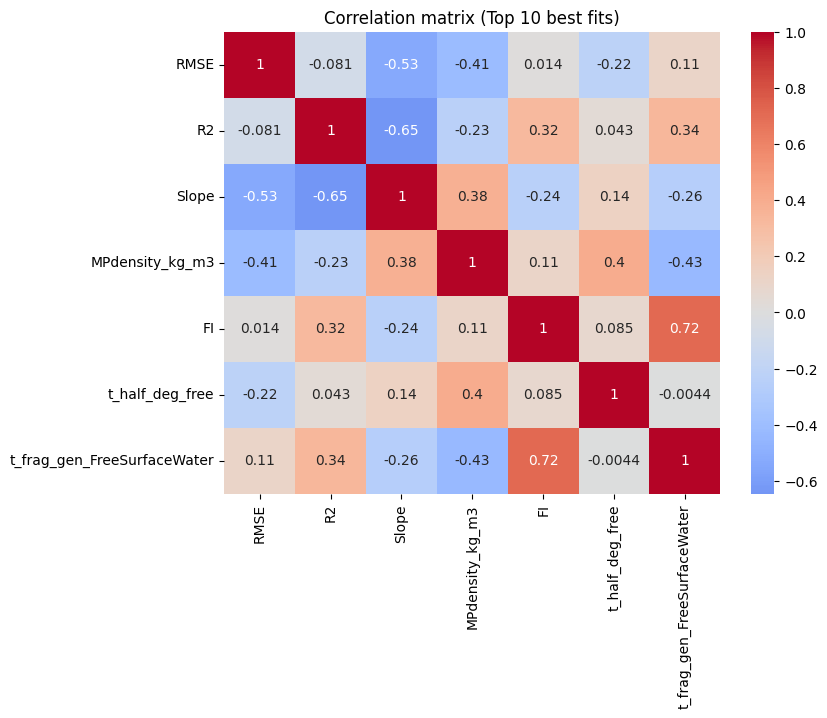

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = top_results[["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 10 best fits)")
plt.show()


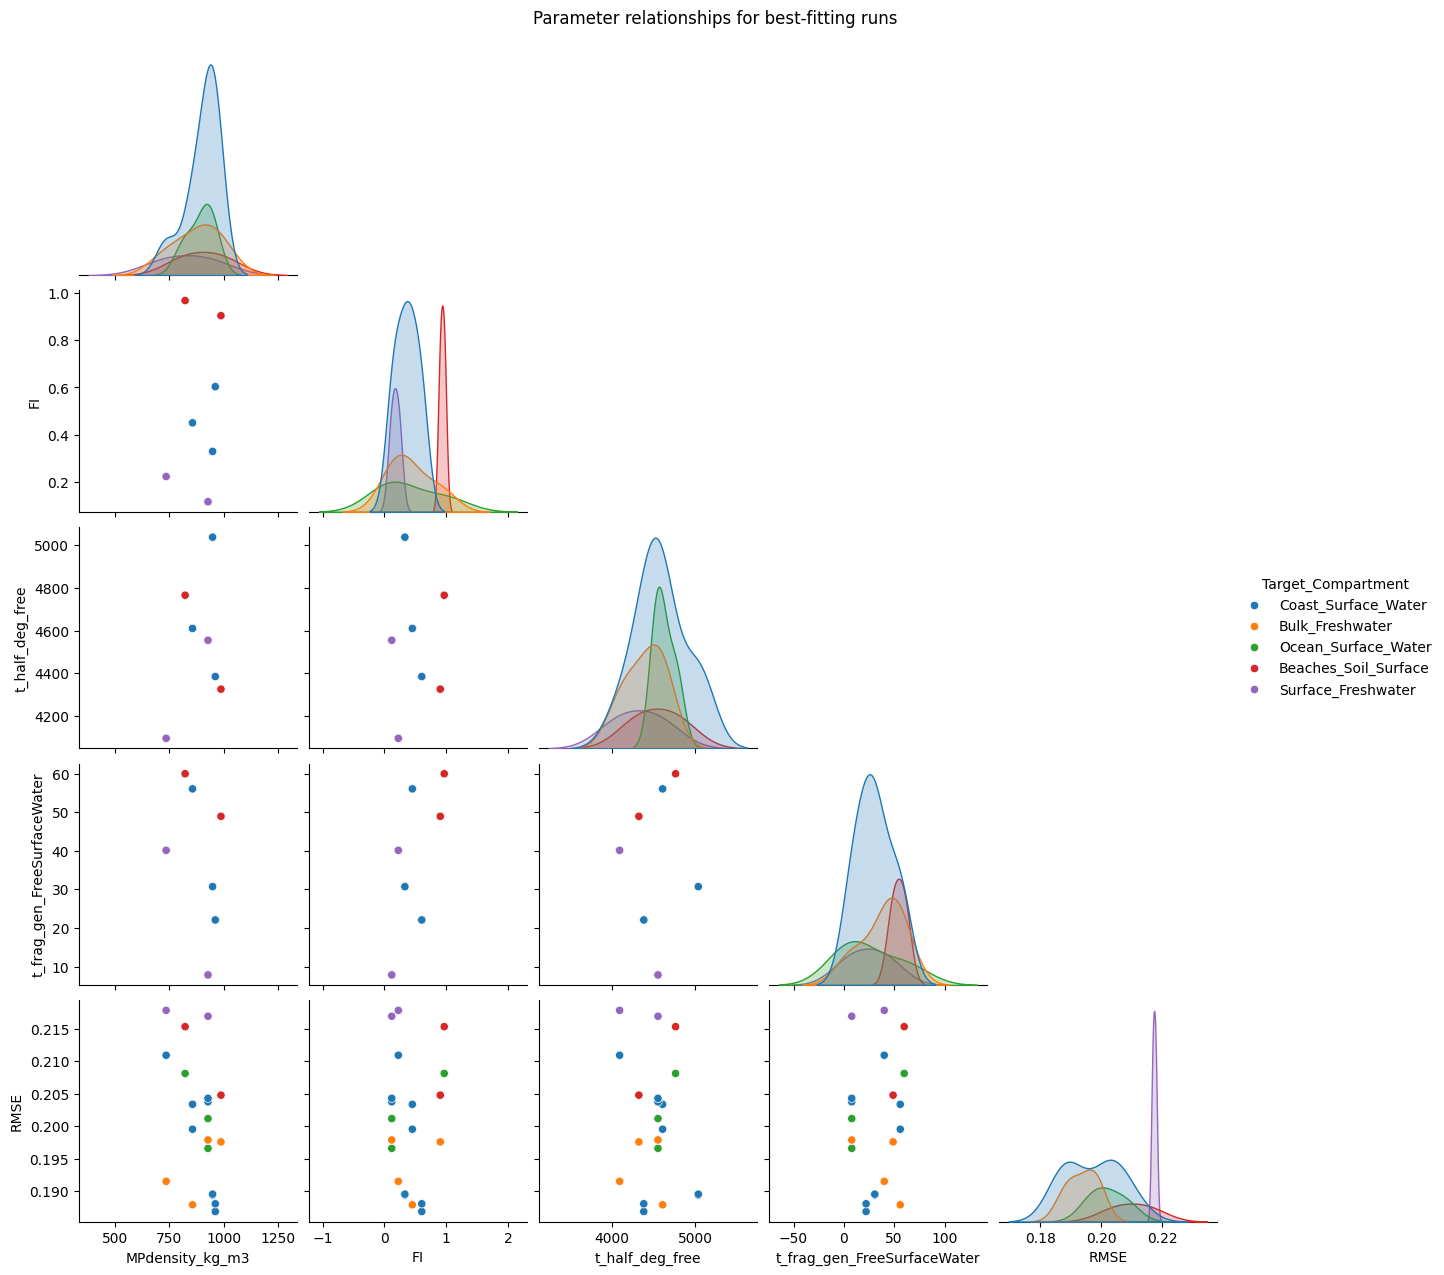

In [14]:
# Pair-wise relationships for the top results
sns.pairplot(
    top_results,
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()


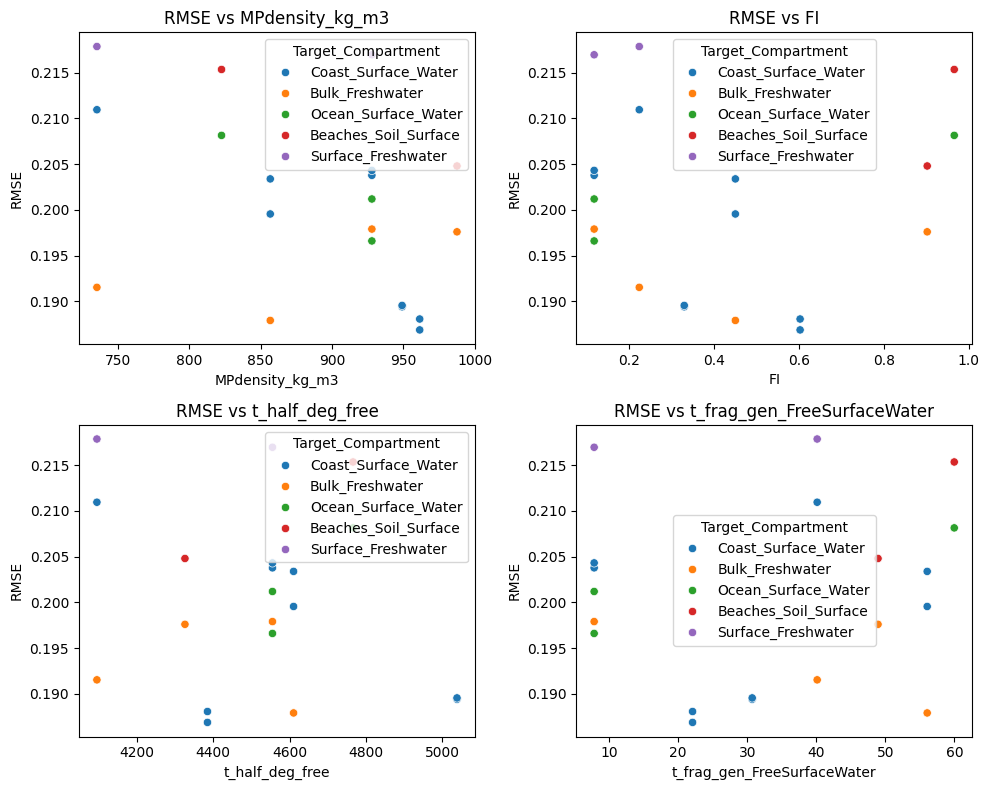

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

params = ["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]

for ax, param in zip(axes.ravel(), params):
    sns.scatterplot(data=top_results, x=param, y="RMSE", hue="Target_Compartment", ax=ax)
    ax.set_title(f"RMSE vs {param}")

plt.tight_layout()
plt.show()


Pearson r = 0.114, p = 6.323e-01
Spearman ρ = 0.130, p = 5.844e-01


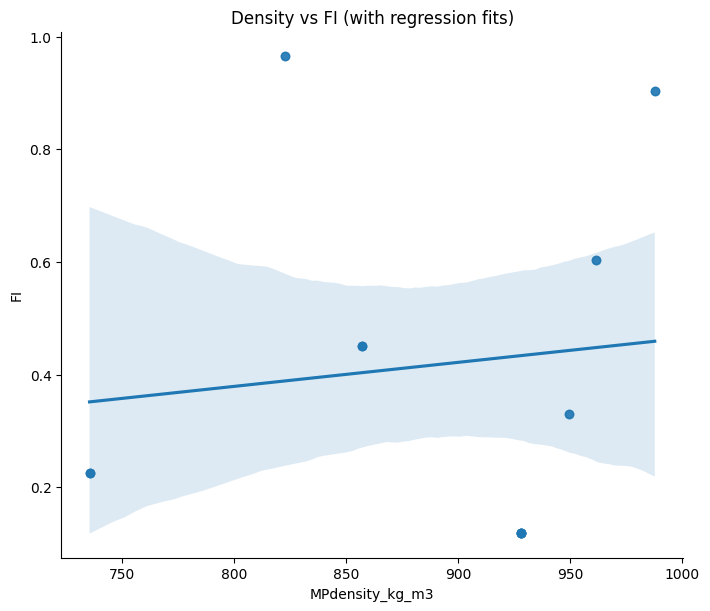

In [31]:
# Pearson & Spearman correlation between Density and FI for all results

# Pearson tests linear correlation.

# Spearman tests monotonic correlation (rank-based, robust to nonlinearities).

# If p < 0.05, the correlation is statistically significant.

from scipy.stats import pearsonr, spearmanr

x = top_results["MPdensity_kg_m3"]
y = top_results["FI"]

pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3e}")
print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=top_results, 
    x="MPdensity_kg_m3", 
    y="FI", 
    #hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()



Best fits Pearson r = 0.114


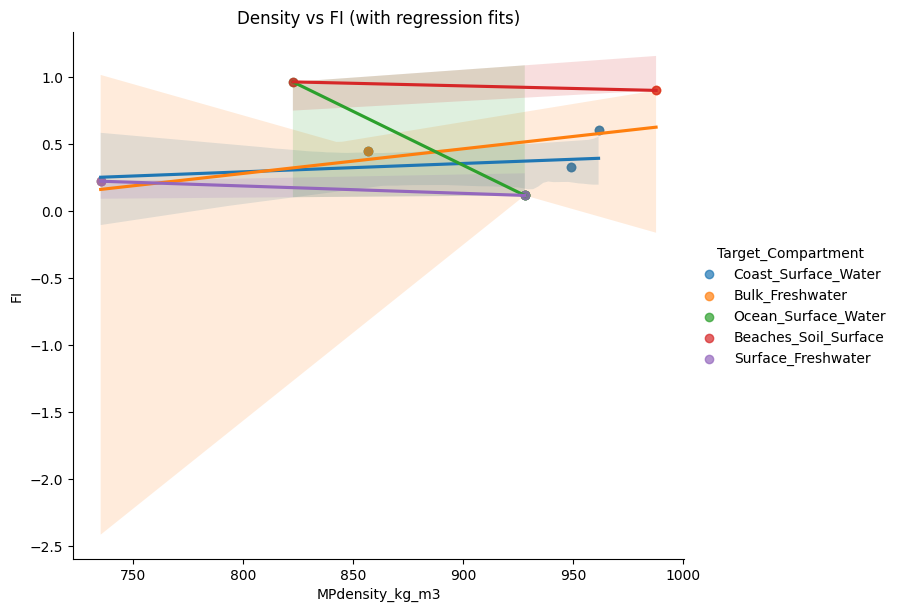

In [ ]:

# Pearson & Spearman correlation between Density and FI for best fits (e.g. lowest 10% RMSE)

threshold = top_results["RMSE"].quantile(0.1)  # lowest 10% of RMSE
best_fits = top_results[top_results["RMSE"] <= threshold]

pearson_corr, _ = pearsonr(best_fits["MPdensity_kg_m3"], best_fits["FI"])
print(f"Best fits Pearson r = {pearson_corr:.3f}")


sns.lmplot(
    data=best_fits, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()

In [20]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Keep only best 10% RMSE across all compartments
threshold = top_results["RMSE"].quantile(0.1)
best_fits = top_results[top_results["RMSE"] <= threshold]

results = []

for comp in best_fits["Target_Compartment"].unique():
    subset = best_fits[best_fits["Target_Compartment"] == comp]
    
    if len(subset) > 2:  # need at least 3 points
        pearson_corr, pearson_p = pearsonr(subset["MPdensity_kg_m3"], subset["FI"])
        spearman_corr, spearman_p = spearmanr(subset["MPdensity_kg_m3"], subset["FI"])
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = [None]*4
    
    results.append({
        "Target_Compartment": comp,
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_rho": spearman_corr,
        "Spearman_p": spearman_p,
        "n_points": len(subset)
    })

correlation_best = pd.DataFrame(results)
print(correlation_best)


    Target_Compartment Pearson_r Pearson_p Spearman_rho Spearman_p  n_points
0  Coast_Surface_Water      None      None         None       None         1
1      Bulk_Freshwater      None      None         None       None         1


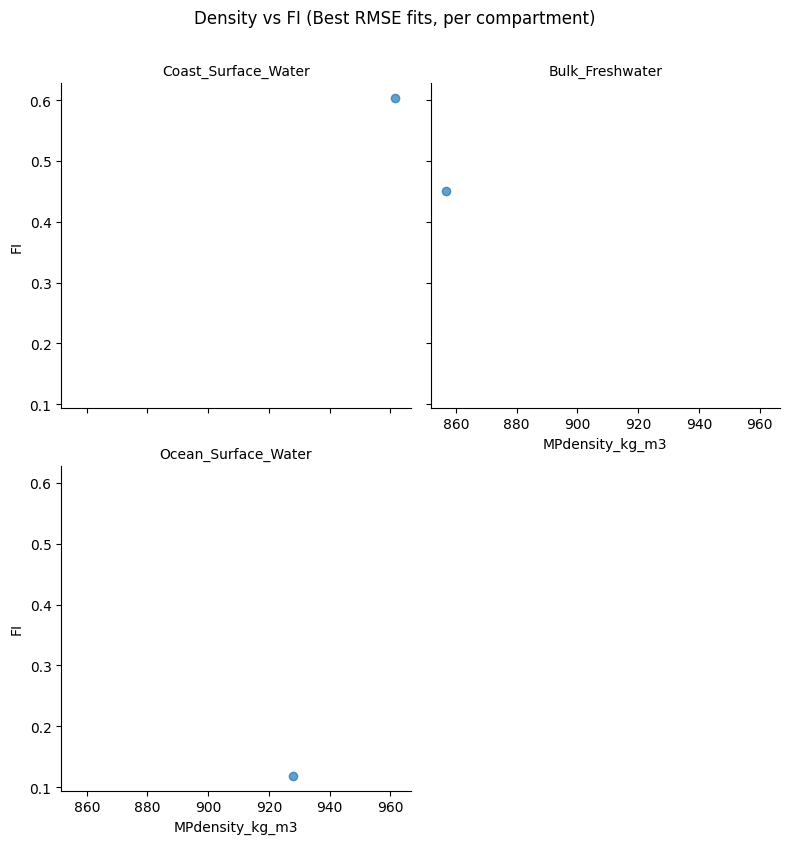

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- pick best fits per compartment (lowest 10% RMSE) ---
best_fits_list = []

for comp in top_results["Target_Compartment"].unique():
    subset = top_results[top_results["Target_Compartment"] == comp]
    if len(subset) > 2:
        threshold = subset["RMSE"].quantile(0.1)   # lowest 10%
        best_subset = subset[subset["RMSE"] <= threshold]
        best_fits_list.append(best_subset)

best_fits = pd.concat(best_fits_list, ignore_index=True)

# --- plot each compartment separately ---
g = sns.lmplot(
    data=best_fits,
    x="MPdensity_kg_m3",
    y="FI",
    col="Target_Compartment",   # separate plot per compartment
    col_wrap=2,                 # wrap panels (2 per row)
    height=4,
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "black"}
)

g.set_titles("{col_name}")
plt.suptitle("Density vs FI (Best RMSE fits, per compartment)", y=1.05)
plt.show()



### Plot sensitivity indices for each output variable.  Monaco uses the D-VARS approach to calculating global sensitivity indices.

In [23]:
sim.outvars

{'Spearman_r': <monaco.mc_var.OutVar at 0x16cc2281650>,
 'Spearman_p': <monaco.mc_var.OutVar at 0x16cbfaadc90>,
 'Pass_Spearman': <monaco.mc_var.OutVar at 0x16cbd9294d0>,
 'RMSE': <monaco.mc_var.OutVar at 0x16cbfb8df50>,
 'R_squared': <monaco.mc_var.OutVar at 0x16cbfb8c990>,
 'Model_slope': <monaco.mc_var.OutVar at 0x16cc1deb590>,
 'Model_intercept': <monaco.mc_var.OutVar at 0x16cc1deba90>,
 'Target_compartment': <monaco.mc_var.OutVar at 0x16cc1dea490>,
 'Emission_compartment': <monaco.mc_var.OutVar at 0x16cc1de8550>}

In [24]:
sim.calcSensitivities("C_g_m3_Ocean_Surface_Water")
fig, ax = sim.outvars["C_g_m3_Ocean_Surface_Water"].plotSensitivities()

KeyError: 'C_g_m3_Ocean_Surface_Water'

In [25]:
sim.calcSensitivities("persistence_number")
fig, ax = sim.outvars["persistence_number"].plotSensitivities()

KeyError: 'persistence_number'

Variable: Spearman_r
Calculating sensitivity indices for 'Spearman_r'...
Calculating optimal hyperparameters Φ for 'Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


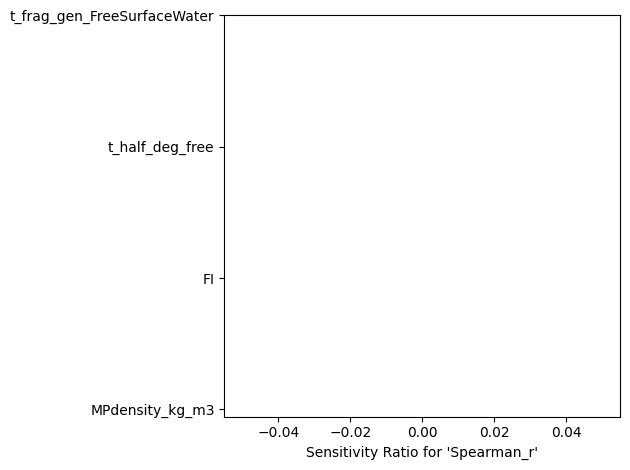

Variable: Spearman_p
Calculating sensitivity indices for 'Spearman_p'...
Calculating optimal hyperparameters Φ for 'Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


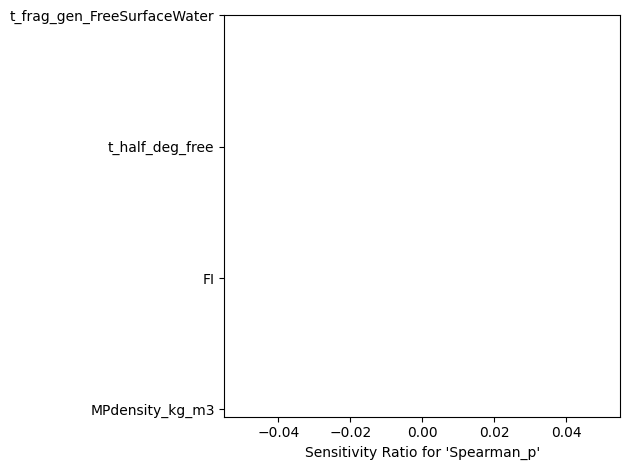

Variable: Pass_Spearman
Calculating sensitivity indices for 'Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


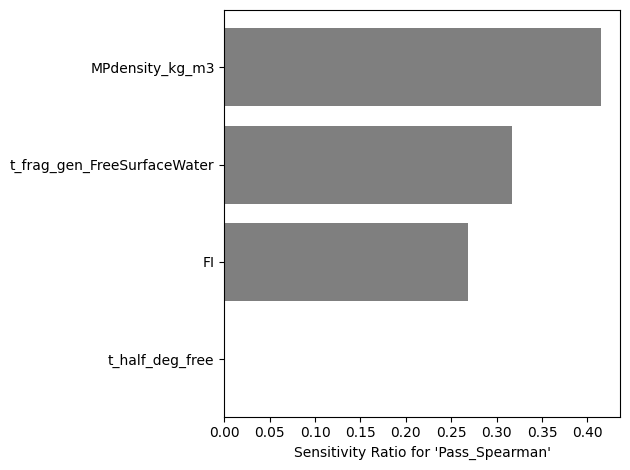

Variable: RMSE
Calculating sensitivity indices for 'RMSE'...
Calculating optimal hyperparameters Φ for 'RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


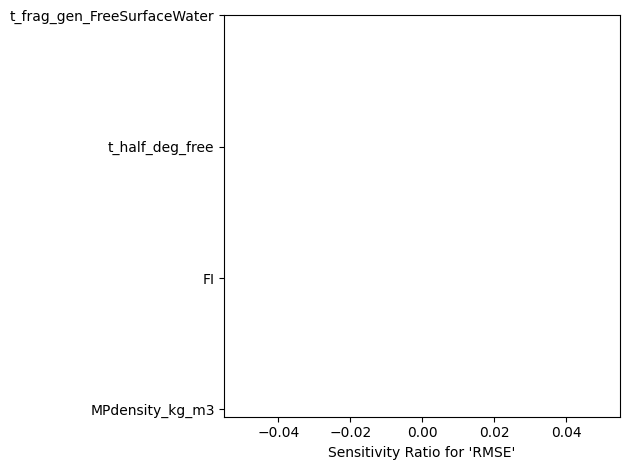

Variable: R_squared
Calculating sensitivity indices for 'R_squared'...
Calculating optimal hyperparameters Φ for 'R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


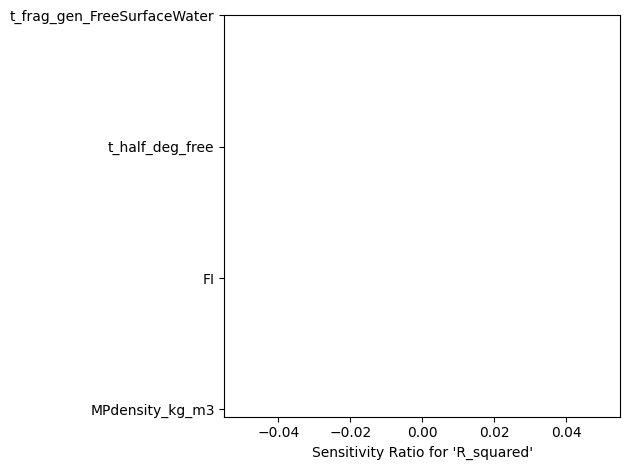

Variable: Model_slope
Calculating sensitivity indices for 'Model_slope'...
Calculating optimal hyperparameters Φ for 'Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


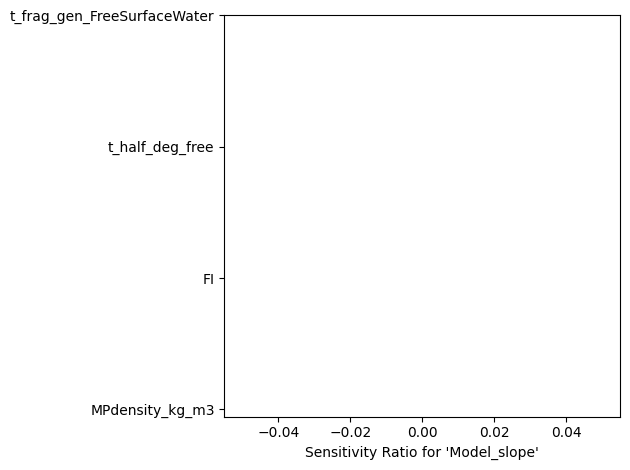

Variable: Model_intercept
Calculating sensitivity indices for 'Model_intercept'...
Calculating optimal hyperparameters Φ for 'Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


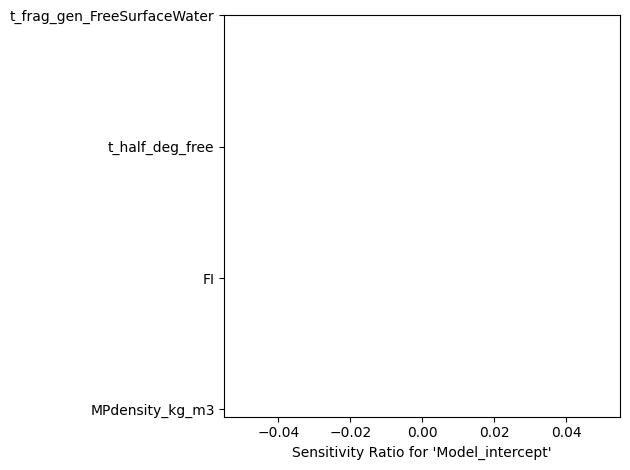

Variable: Target_compartment
Calculating sensitivity indices for 'Target_compartment'...
Calculating optimal hyperparameters Φ for 'Target_compartment' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:277: RuntimeWarning: divide by zero encountered in log
  L = np.log(Rdet)/m + m*np.log(L_inner.T @ Rinv @ L_inner)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:93: RuntimeWarning: invalid value encountered in divide
  ratios = sensitivities/sum(sensitivities)


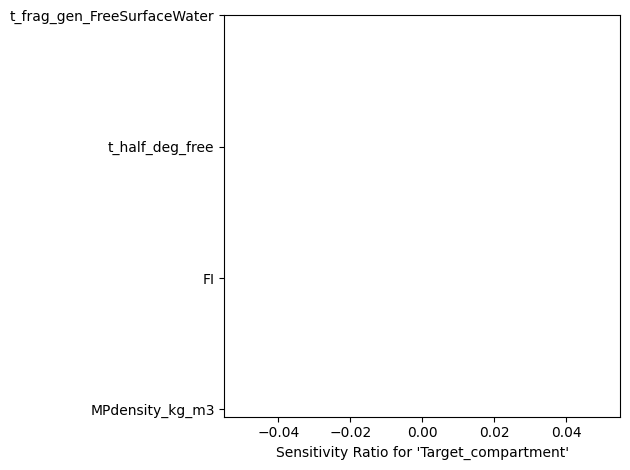

Variable: Emission_compartment
Calculating sensitivity indices for 'Emission_compartment'...
Calculating optimal hyperparameters Φ for 'Emission_compartment' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:277: RuntimeWarning: divide by zero encountered in log
  L = np.log(Rdet)/m + m*np.log(L_inner.T @ Rinv @ L_inner)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:93: RuntimeWarning: invalid value encountered in divide
  ratios = sensitivities/sum(sensitivities)


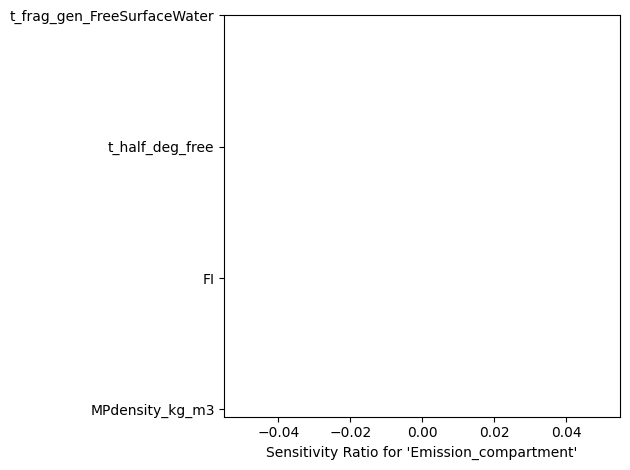

In [26]:
import matplotlib.pyplot as plt

for var in sim.outvars:
    print(f"Variable: {var}")
    sim.calcSensitivities(var)
    fig, ax = sim.outvars[var].plotSensitivities()

    plt.show()

### Plot 

In [80]:
sim.outvars.keys()

dict_keys(['Coast_Surface_Water_Spearman_r', 'Coast_Surface_Water_Spearman_p', 'Coast_Surface_Water_Pass_Spearman', 'Coast_Surface_Water_RMSE', 'Coast_Surface_Water_R_squared', 'Coast_Surface_Water_Model_slope', 'Coast_Surface_Water_Model_intercept', 'Ocean_Surface_Water_Spearman_r', 'Ocean_Surface_Water_Spearman_p', 'Ocean_Surface_Water_Pass_Spearman', 'Ocean_Surface_Water_RMSE', 'Ocean_Surface_Water_R_squared', 'Ocean_Surface_Water_Model_slope', 'Ocean_Surface_Water_Model_intercept', 'residence_time_mass', 'residence_time_number', 'persistence_mass', 'persistence_number'])

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='persistence_mass'>,
  <Axes: >))

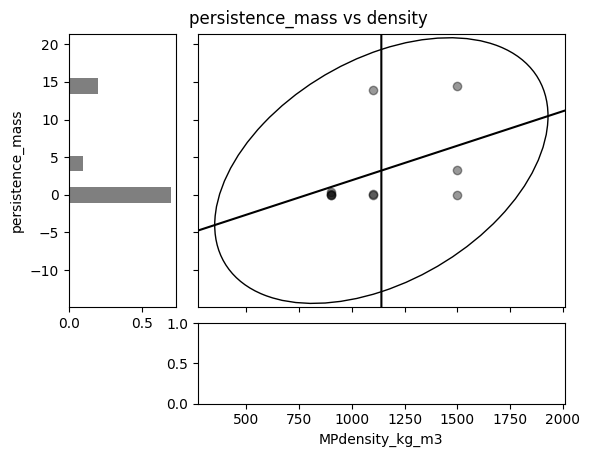

In [81]:

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["persistence_mass"]],title="persistence_mass vs density",cov_plot=True)